In [1]:
import argparse
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
# Loading relevant libraries and the dataset
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

from scipy.io import loadmat
import matplotlib
%matplotlib inline

global maximum
maximum={}

minimumAlert=5
showChartBool=True
latex=(not showChartBool)

obsWindows=[32, 64]
slidingValue=16
featuresIndex=None#Used to filter for some features
window=64 #or 32

datasets={
    "train":{
        "normal":"datasets/train/normal.txt"
    },
    "test":{
        "normal":"datasets/test/normal.txt",
        "brute_isolated":"datasets/test/brute_isolated.txt",
        "brute_mixed":"datasets/test/brute_mixed.txt",
        "smooth_isolated":"datasets/test/smooth_isolated.txt",
        "smooth_mixed":"datasets/test/smooth_mixed.txt",
        "intelligent":"datasets/test/intelligent.txt"
    },
    "validation":{
        "normal":"datasets/validation/normal.txt",
        "brute_isolated":"datasets/validation/brute_isolated.txt",
        "brute_mixed":"datasets/validation/brute_mixed.txt",
        "smooth_isolated":"datasets/validation/smooth_isolated.txt",
        "smooth_mixed":"datasets/validation/smooth_mixed.txt",
        "intelligent":"datasets/validation/intelligent.txt"
    }
}

In [2]:
def extractStats(data):
    nSamp,nCols=data.shape

    M1=np.mean(data,axis=0)
    Md1=np.median(data,axis=0)
    Std1=np.std(data,axis=0)
    
    features=np.hstack((M1,Md1,Std1))
    return(features)

def extratctSilenceActivity(data,threshold=0):
    if(data[0]<=threshold):
        s=[1]
        a=[]
    else:
        s=[]
        a=[1]
    for i in range(1,len(data)):
        if(data[i-1]>threshold and data[i]<=threshold):
            s.append(1)
        elif(data[i-1]<=threshold and data[i]>threshold):
            a.append(1)
        elif (data[i-1]<=threshold and data[i]<=threshold):
            s[-1]+=1
        else:
            a[-1]+=1
    return(s,a)
    
def extractStatsSilenceActivity(data):
    features=[]
    nSamples,nMetrics=data.shape
    silence_features=np.array([])
    activity_features=np.array([])
    for c in range(0, nMetrics, 2): #Use only one column from upload and another from download
        silence,activity=extratctSilenceActivity(data[:,c],threshold=0)
        
        if len(silence)>0:
            silence_faux=np.array([len(silence),np.mean(silence),np.std(silence)])
        else:
            silence_faux=np.zeros(3)
        silence_features=np.hstack((silence_features,silence_faux))
        
        if len(activity)>0:
            activity_faux=np.array([len(activity),np.mean(activity),np.std(activity)])
        else:
            activity_faux=np.zeros(3)
        activity_features=np.hstack((activity_features,activity_faux))	   
    features=np.hstack((silence_features,activity_features))
    return(features)

### Function: slidingMultObsWindow
This function returns all the extracted features. The return is a dict containing the windows size (as key) and the list of features extracted from that windows (as value).
Index of the features in the array:
1. Window of 32 seconds:
    1. Mean (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    2. Median (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    3. Standard deviation (4 columns: Up Size, Up Count, Down Size, Down Count)
    4. Silence (6 columns: Mean, Median and Standard deviation for Upload and Download size)
    5. Activity (6 columns: Mean, Median and Standard deviation for Upload and Download size)
1. Window of 64 seconds:
    1. Mean (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    2. Median (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    3. Standard deviation (4 columns: Up Size, Up Count, Down Size, Down Count)
    4. Silence (6 columns: Mean, Median and Standard deviation for Upload and Download size)
    5. Activity (6 columns: Mean, Median and Standard deviation for Upload and Download size)


In [3]:
def slidingMultObsWindow(data,lengthObsWindow,slidingValue, filterIndex=None, defineMax=False):
    nSamples,nMetrics=data.shape
    #Fix windows
    results = {}
    for s in np.arange(max(lengthObsWindow),nSamples,slidingValue):
        features=np.array([])
        for oW in lengthObsWindow:
            if oW not in results:
                results[oW] = []
            subdata=data[s-oW:s,1:]
            faux=extractStats(subdata)
            faux2=extractStatsSilenceActivity(subdata)
            features=np.hstack((features,faux,faux2))
            #print(('{} '*len(features)).format(*features))
            if filterIndex:
                features = features[filterIndex]
            results[oW].append(features)
    
    for oW in lengthObsWindow:
        if oW in results:
            results[oW] = np.array(results[oW])
            global maximum
            if defineMax:
                maximum[oW]=(results[oW].max(axis=0)+np.finfo(np.float32).eps)
            results[oW] = results[oW]/maximum[oW]
            
    return results

In [4]:
def showChart(dataInput):
    if showChartBool:
        name=dataInput.split("/")[1:3]
        print("Traffic from", name[0], "in", name[1], "mode")
        corruptData=np.loadtxt(dataInput,dtype=int)
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.plot(corruptData[:,0],corruptData[:,1],corruptData[:,0],corruptData[:,3])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Packages count')
        plt.subplot(2,1,2)
        plt.plot(corruptData[:,0],corruptData[:,2],corruptData[:,0],corruptData[:,4])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Packages count')
        plt.show()

Traffic from train in normal.txt mode


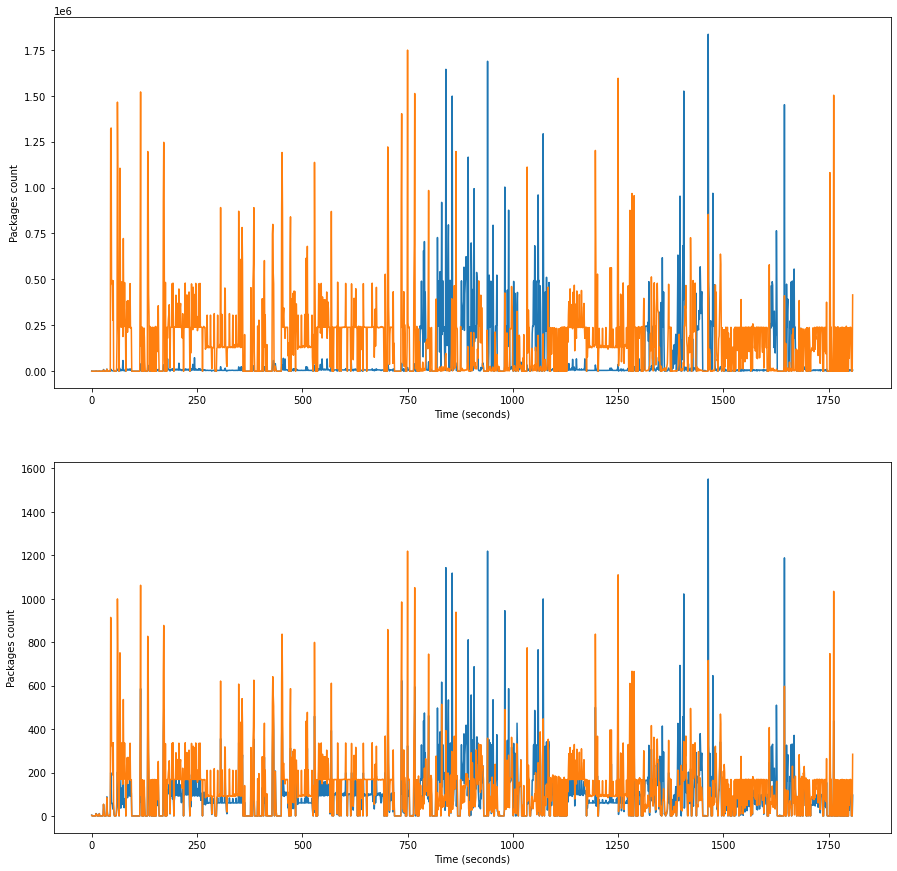

In [5]:
fileInput=datasets["train"]["normal"]
showChart(fileInput)
data=np.loadtxt(fileInput,dtype=int)
normalTraffic = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex, True)

### Load traffic
The traffic is loaded to a dictionary containing only the test and validation datasets.

Traffic from train in normal.txt mode


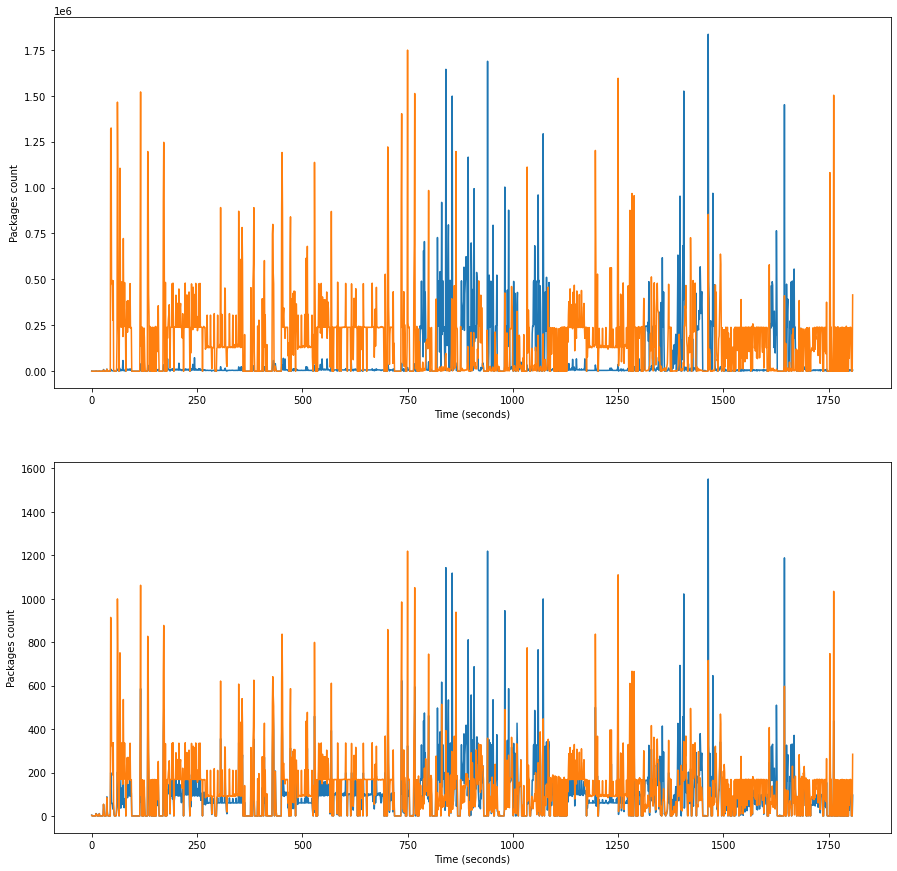

Traffic from test in normal.txt mode


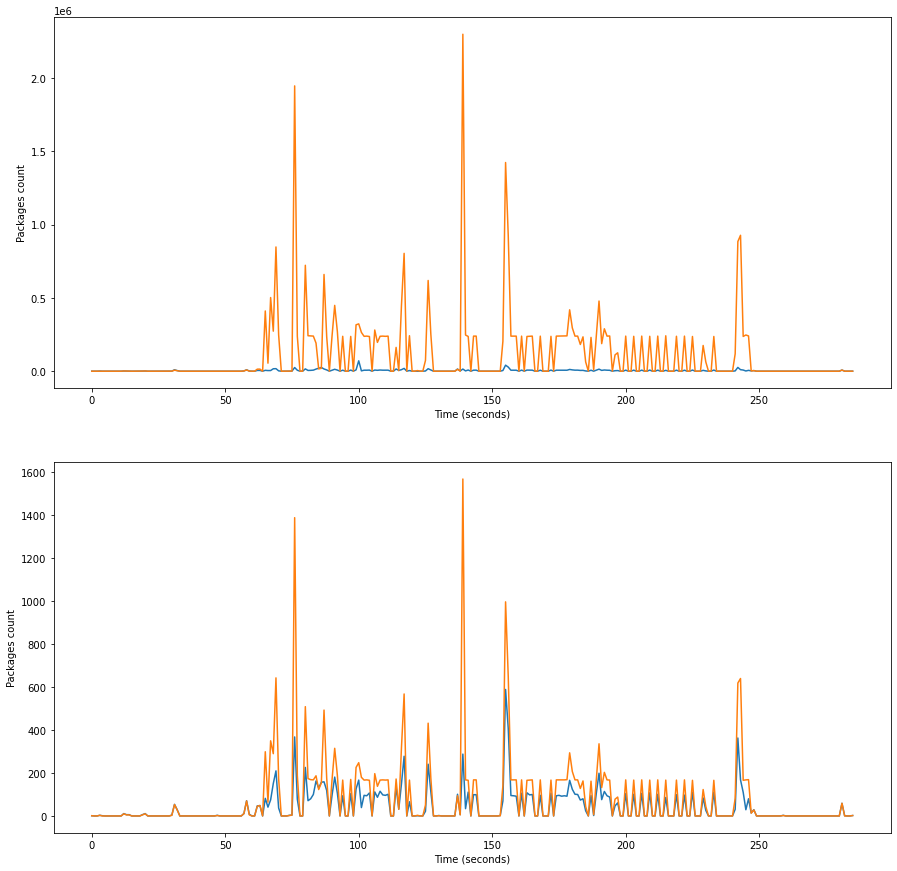

Traffic from test in brute_isolated.txt mode


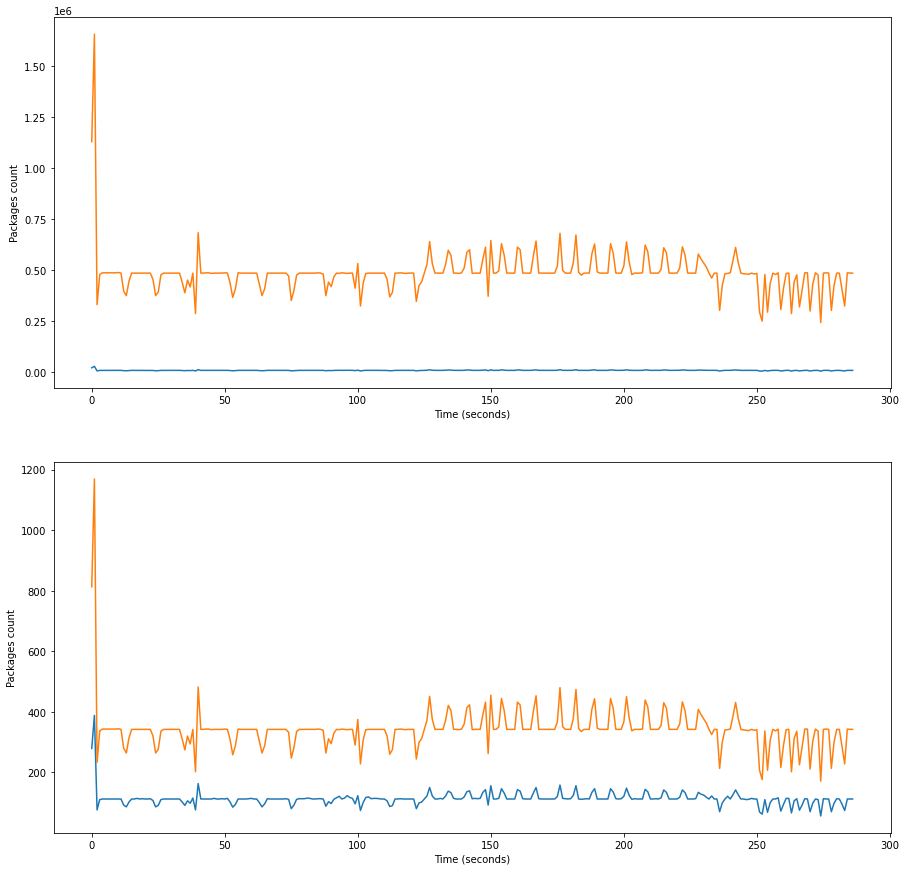

Traffic from test in brute_mixed.txt mode


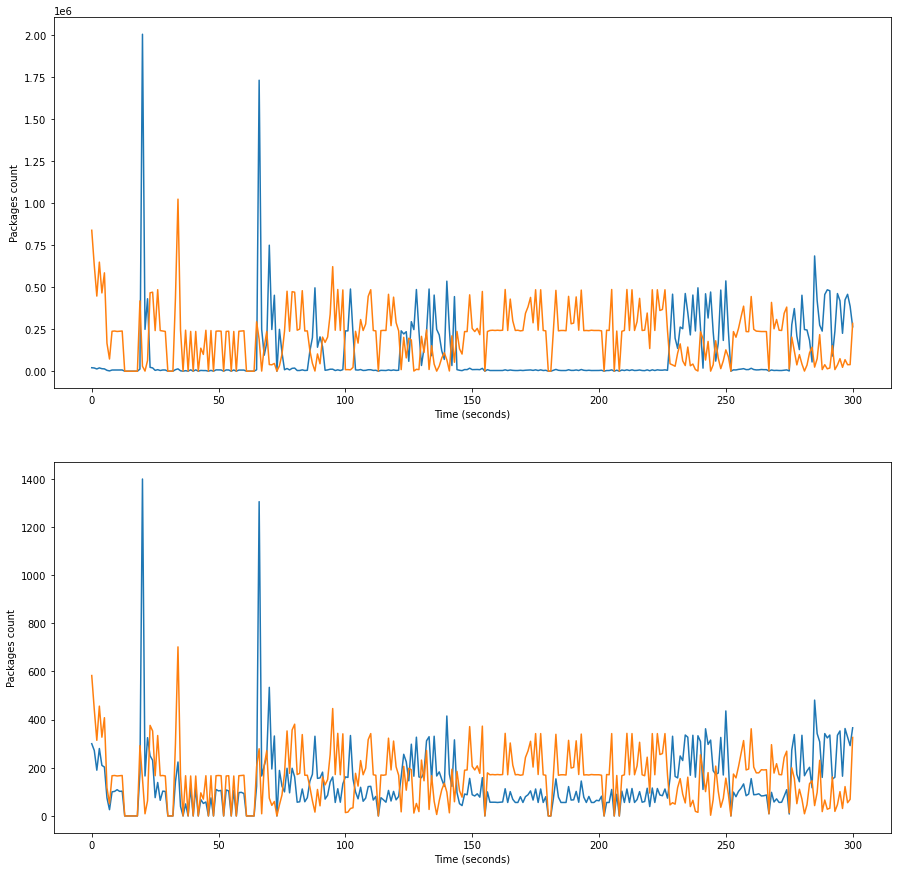

Traffic from test in smooth_isolated.txt mode


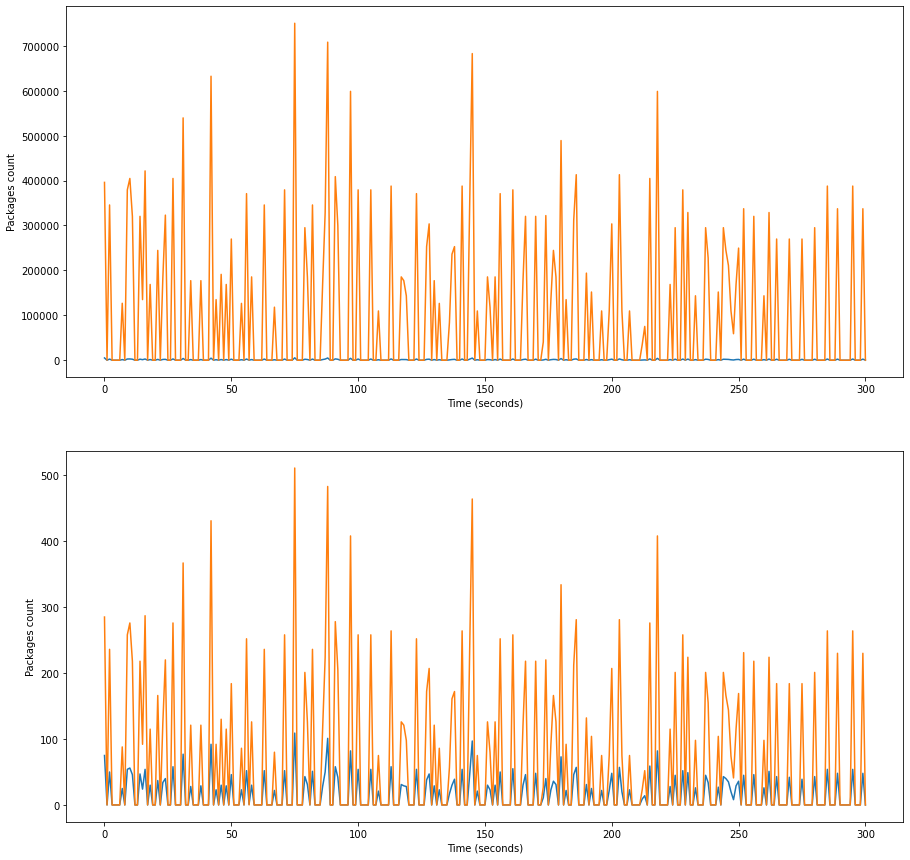

Traffic from test in smooth_mixed.txt mode


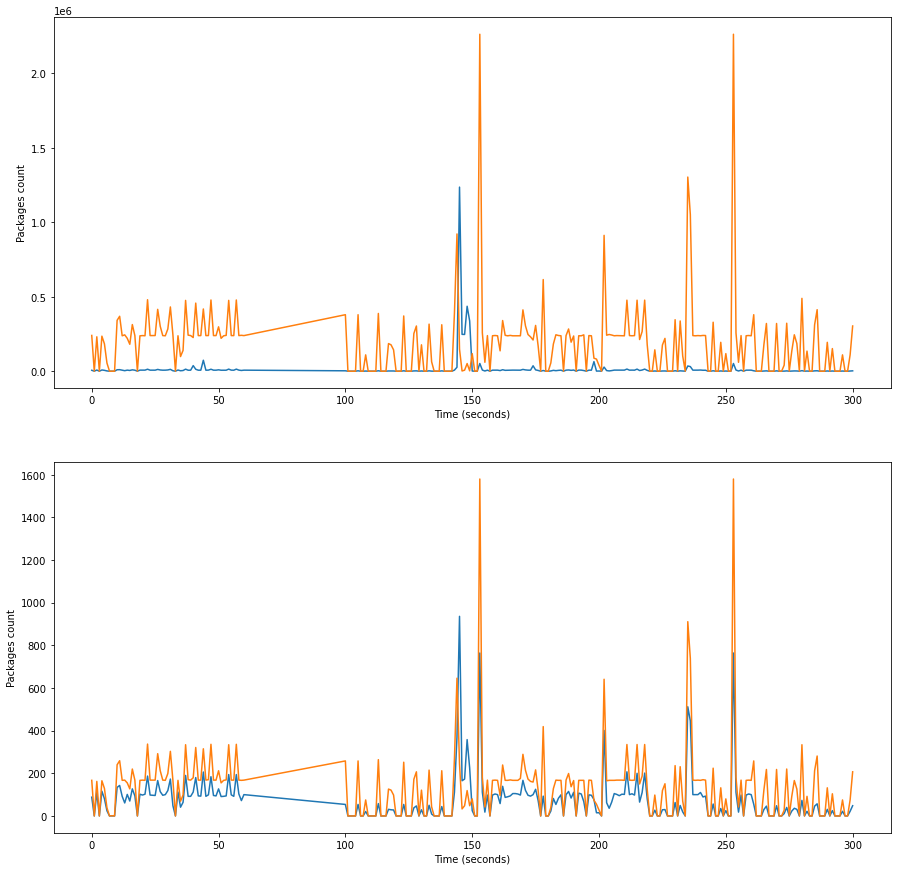

Traffic from test in intelligent.txt mode


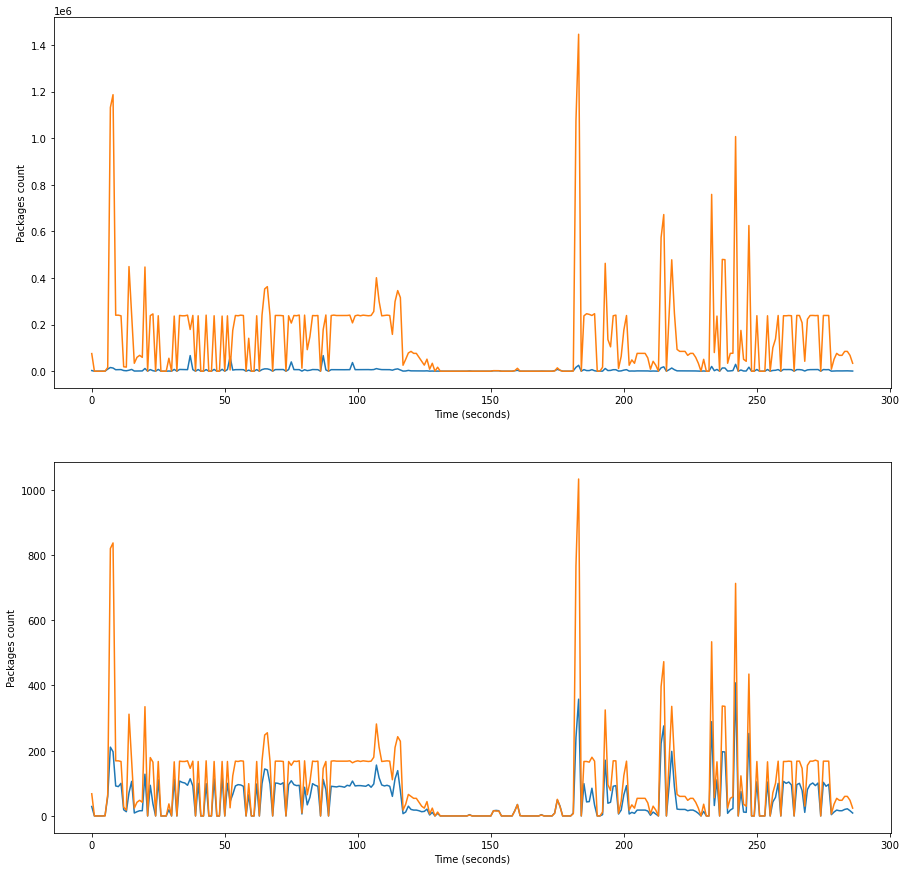

Traffic from validation in normal.txt mode


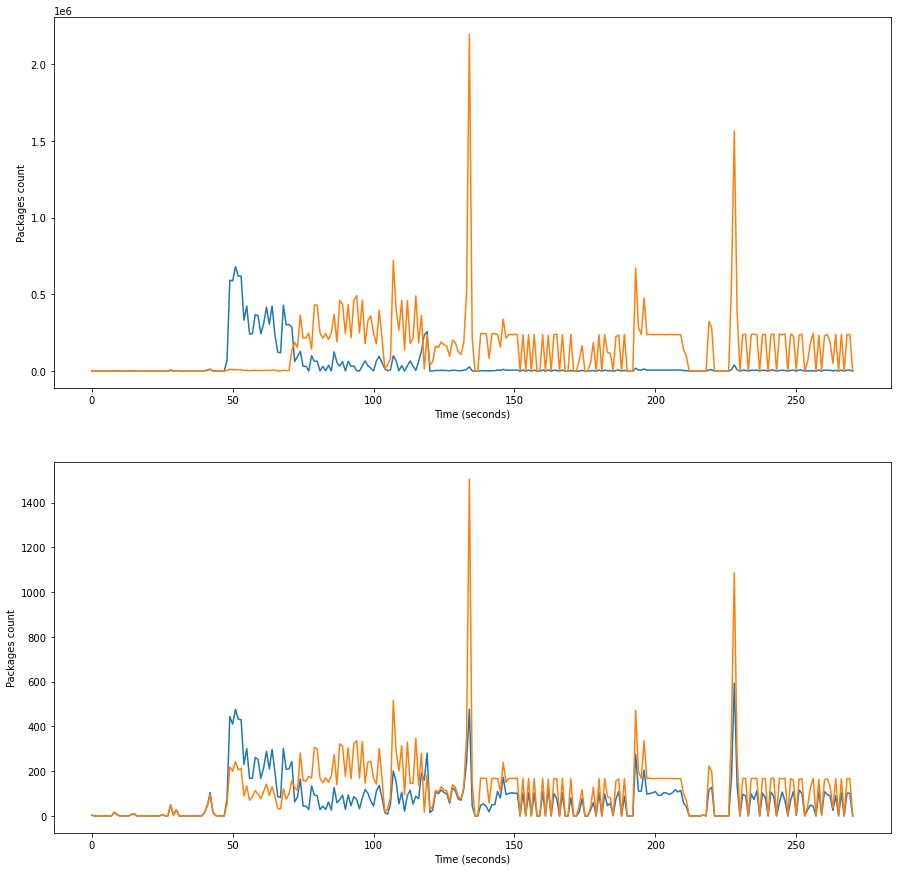

Traffic from validation in brute_isolated.txt mode


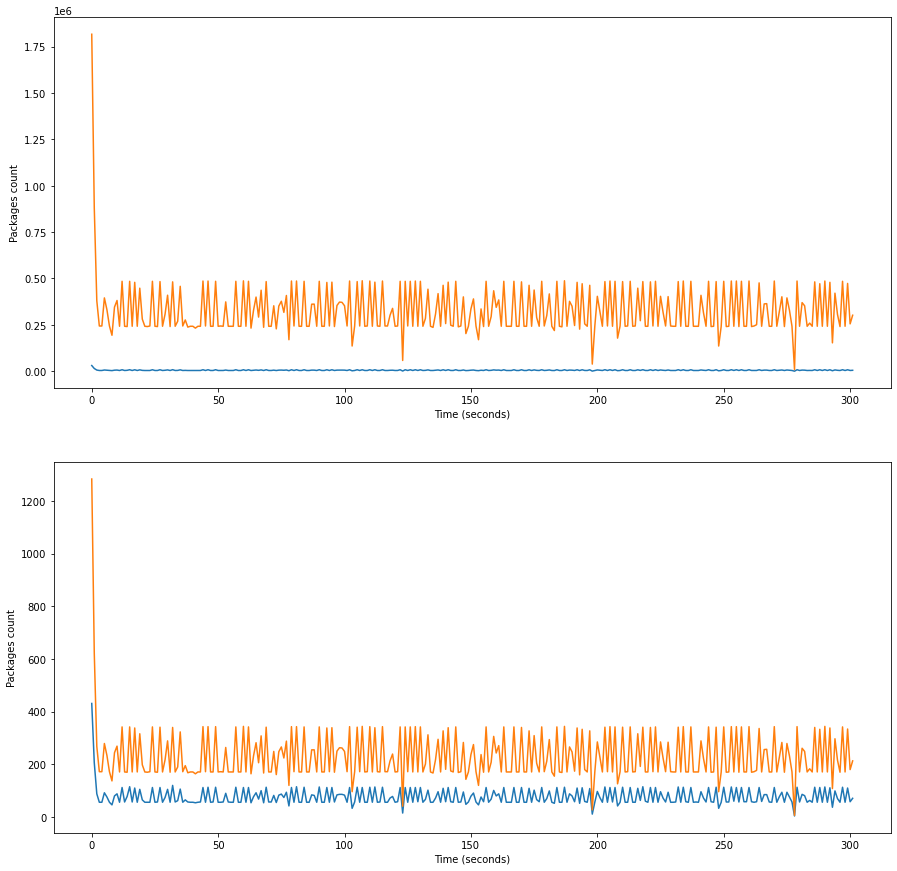

Traffic from validation in brute_mixed.txt mode


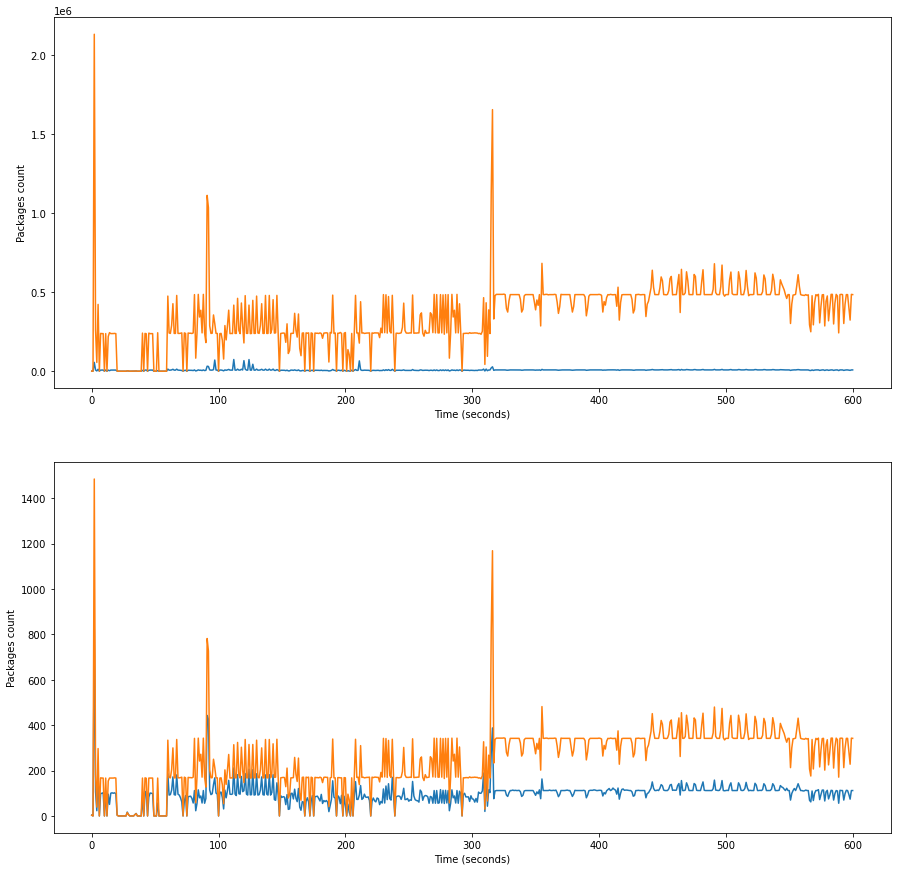

Traffic from validation in smooth_isolated.txt mode


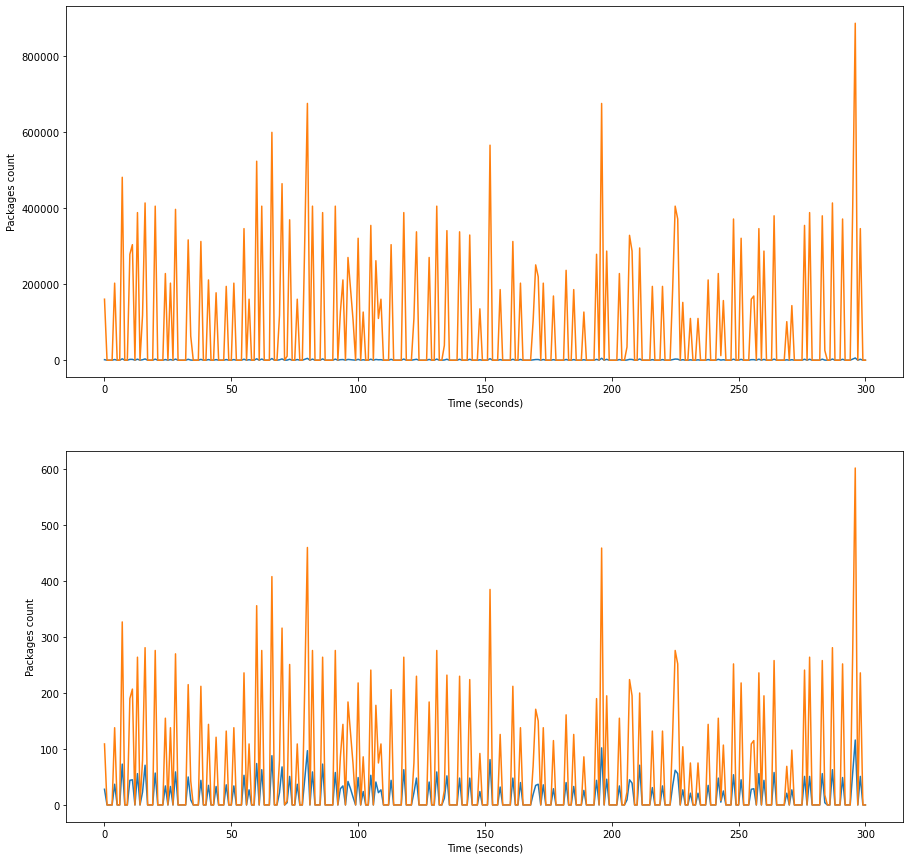

Traffic from validation in smooth_mixed.txt mode


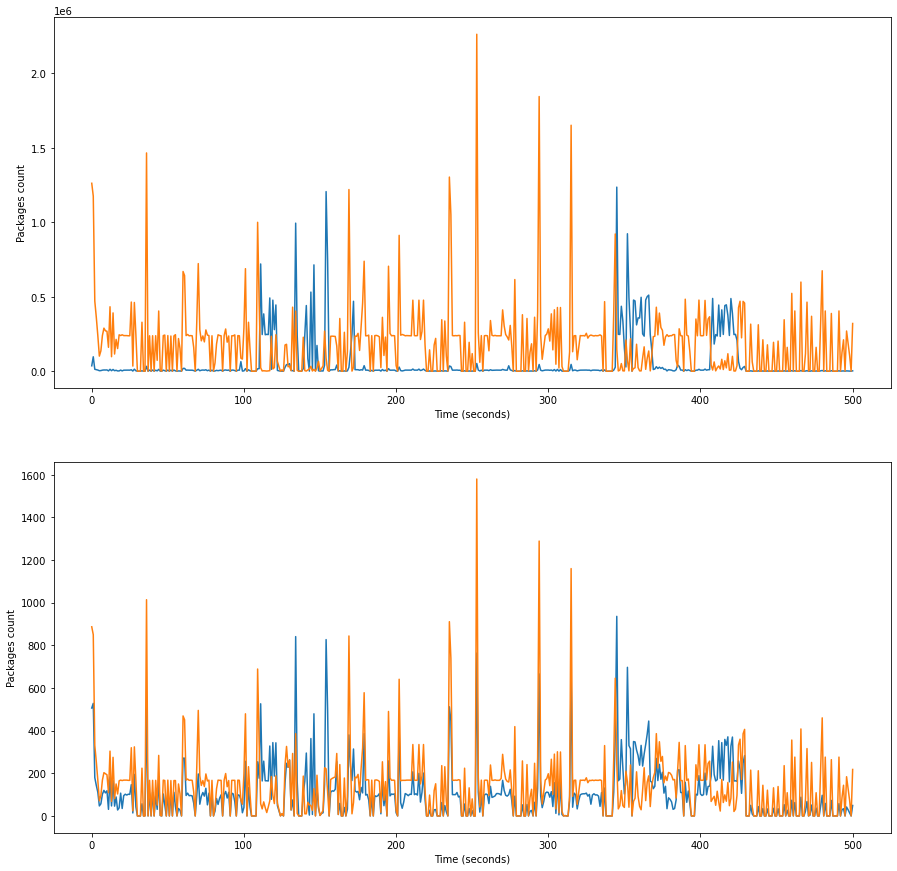

Traffic from validation in intelligent.txt mode


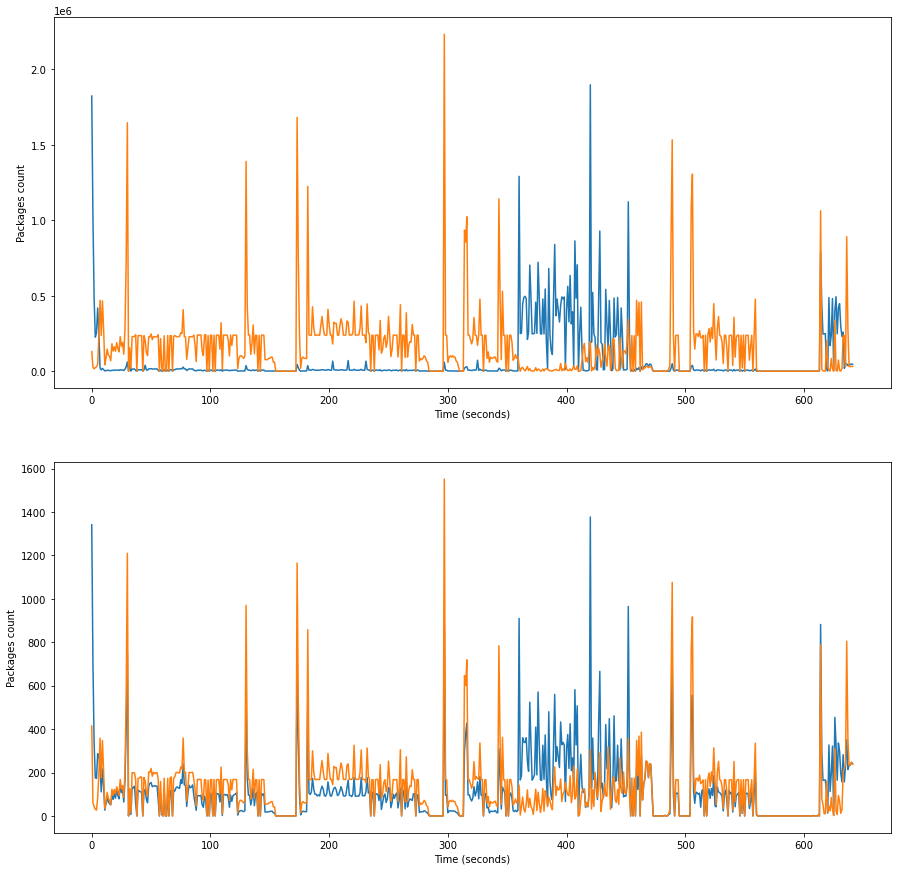

In [6]:
traffic={}
for x in datasets:
    traffic[x]={}
    for ds in datasets[x]:
        fin=datasets[x][ds]
        data=np.loadtxt(fin,dtype=int)
        showChart(fin)
        traffic[x][ds] = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex)[window]

### Chart for 2-Feature Analysis
Define the values for featureA and featureB in order to combine with other charts.
This was used initially to analysed the test dataset. Then, it was added the validation data set.

			Test							Validation


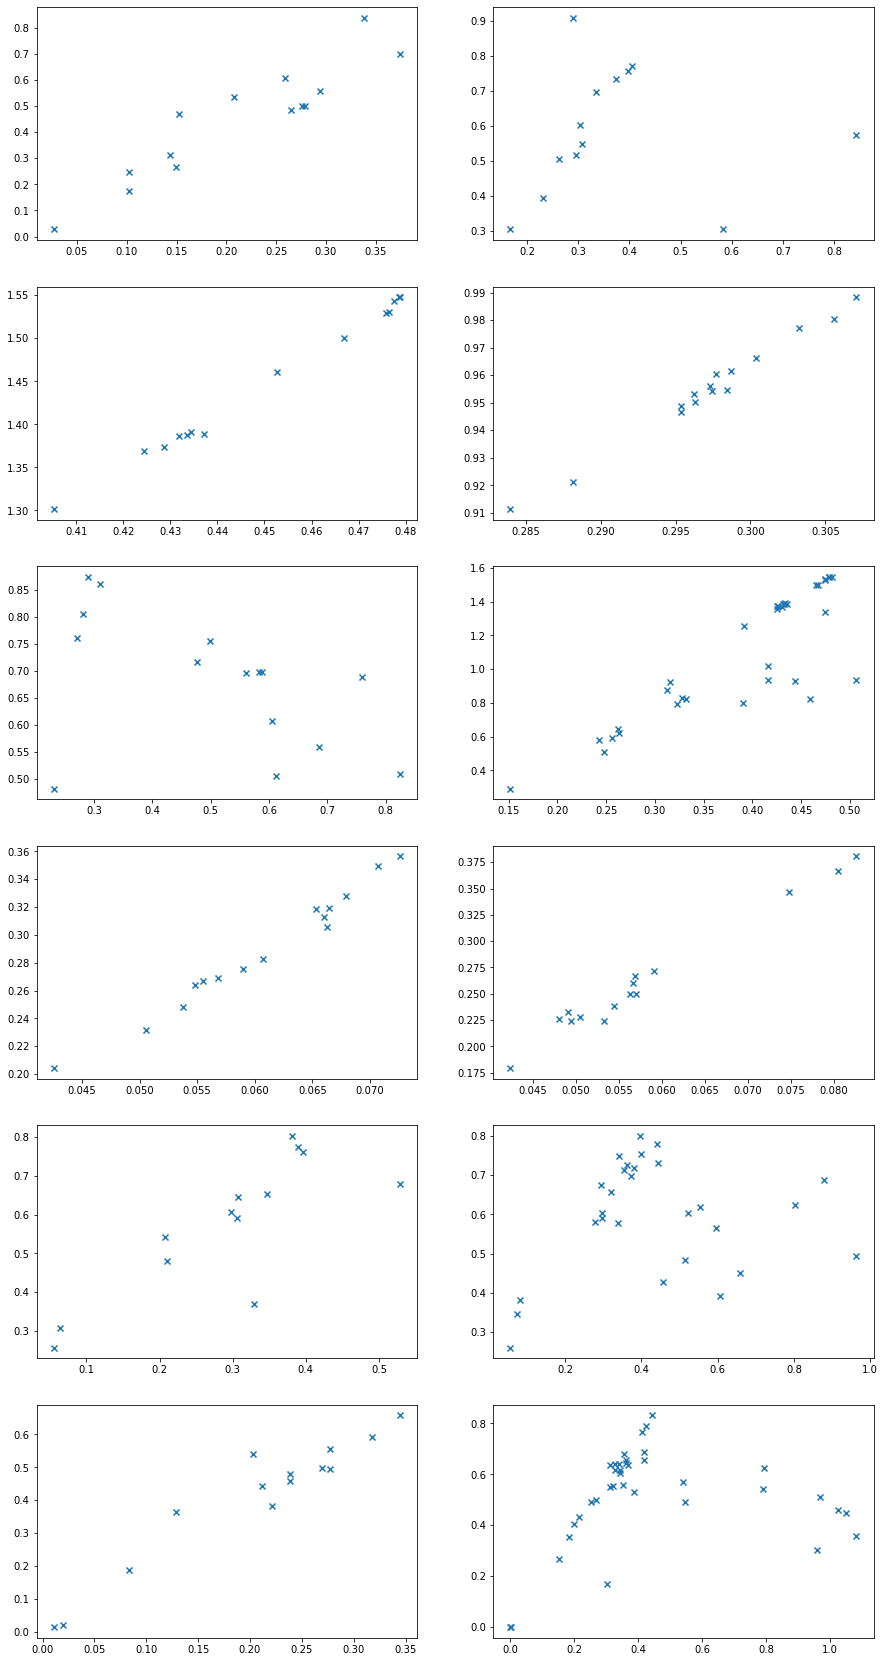

In [7]:
featureA=1
featureB=3

print("\t\t\tTest\t\t\t\t\t\t\tValidation")
plt.figure(figsize=(15,30))
#traffic[x]
idx=1
for x in traffic["test"]:
    trafficTest=traffic["test"][x]
    plt.subplot(6, 2, idx)
    plt.scatter(trafficTest[:, featureA], trafficTest[:, featureB],marker="x")
    idx+=2

idx=2
for x in traffic["validation"]:
    trafficValidation=traffic["validation"][x]
    plt.subplot(6, 2, idx)
    plt.scatter(trafficValidation[:, featureA], trafficValidation[:, featureB],marker="x")
    idx+=2

						Feature A
			Test							Validation


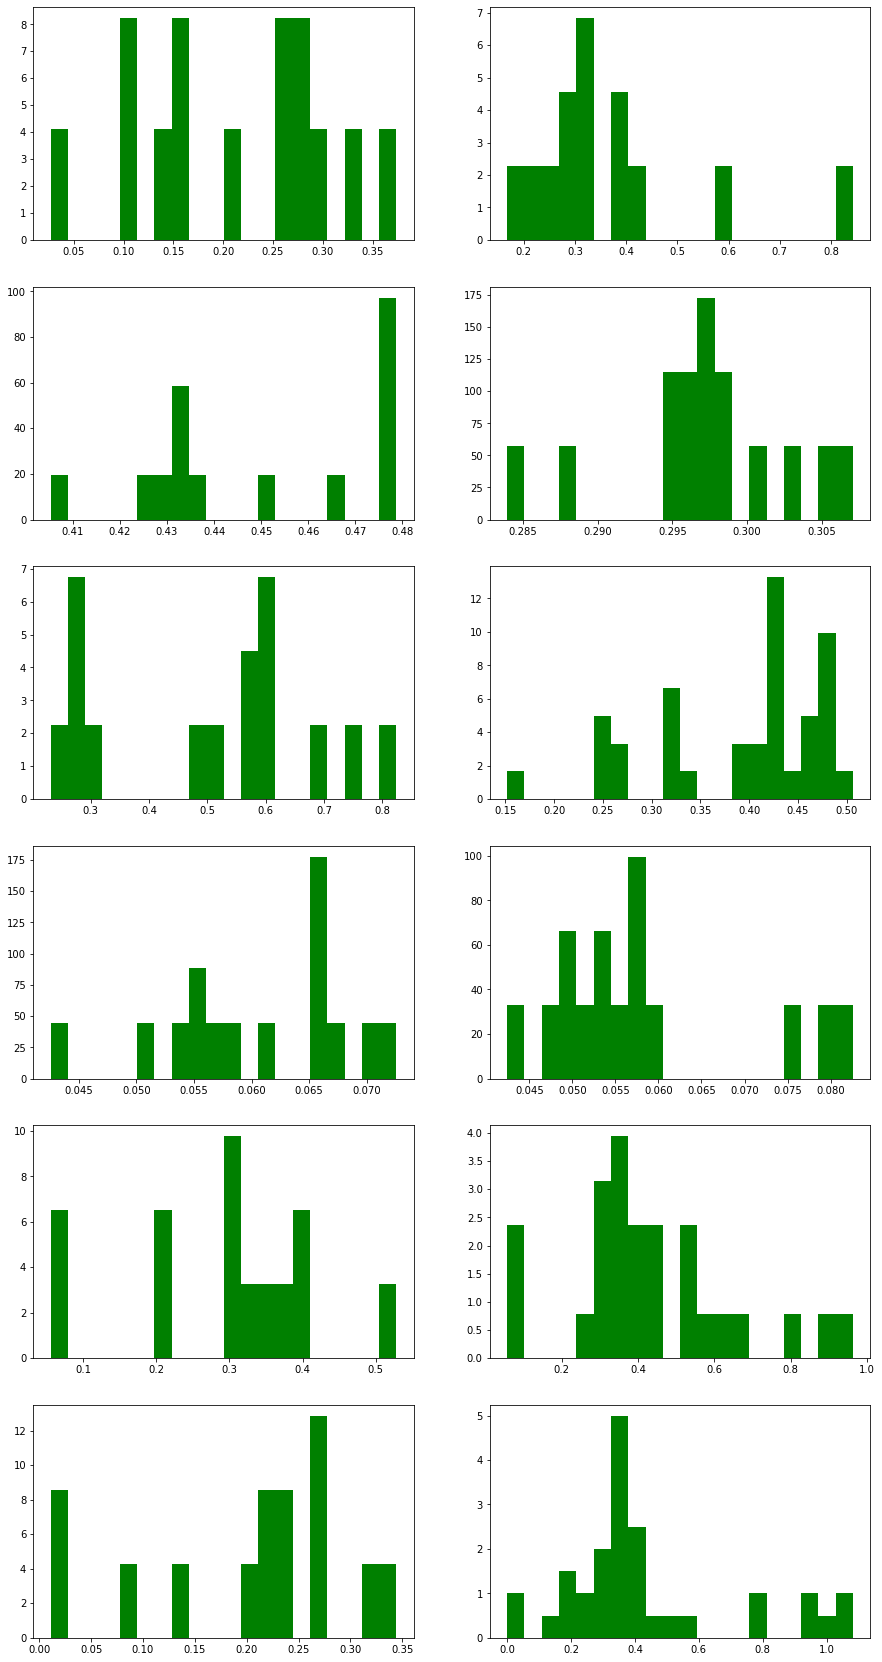

In [8]:
print("\t\t\t\t\t\tFeature A")
print("\t\t\tTest\t\t\t\t\t\t\tValidation")
plt.figure(figsize=(15,30))
#traffic[x]
idx=1
for x in traffic["test"]:
    trafficTest=traffic["test"][x]
    plt.subplot(6, 2, idx)
    plt.hist(trafficTest[:, featureA], 20, density=1, color='g')
    idx+=2

idx=2
for x in traffic["validation"]:
    trafficValidation=traffic["validation"][x]
    plt.subplot(6, 2, idx)
    plt.hist(trafficValidation[:, featureA], 20, density=1, color='g')
    idx+=2

						Feature B
			Test							Validation


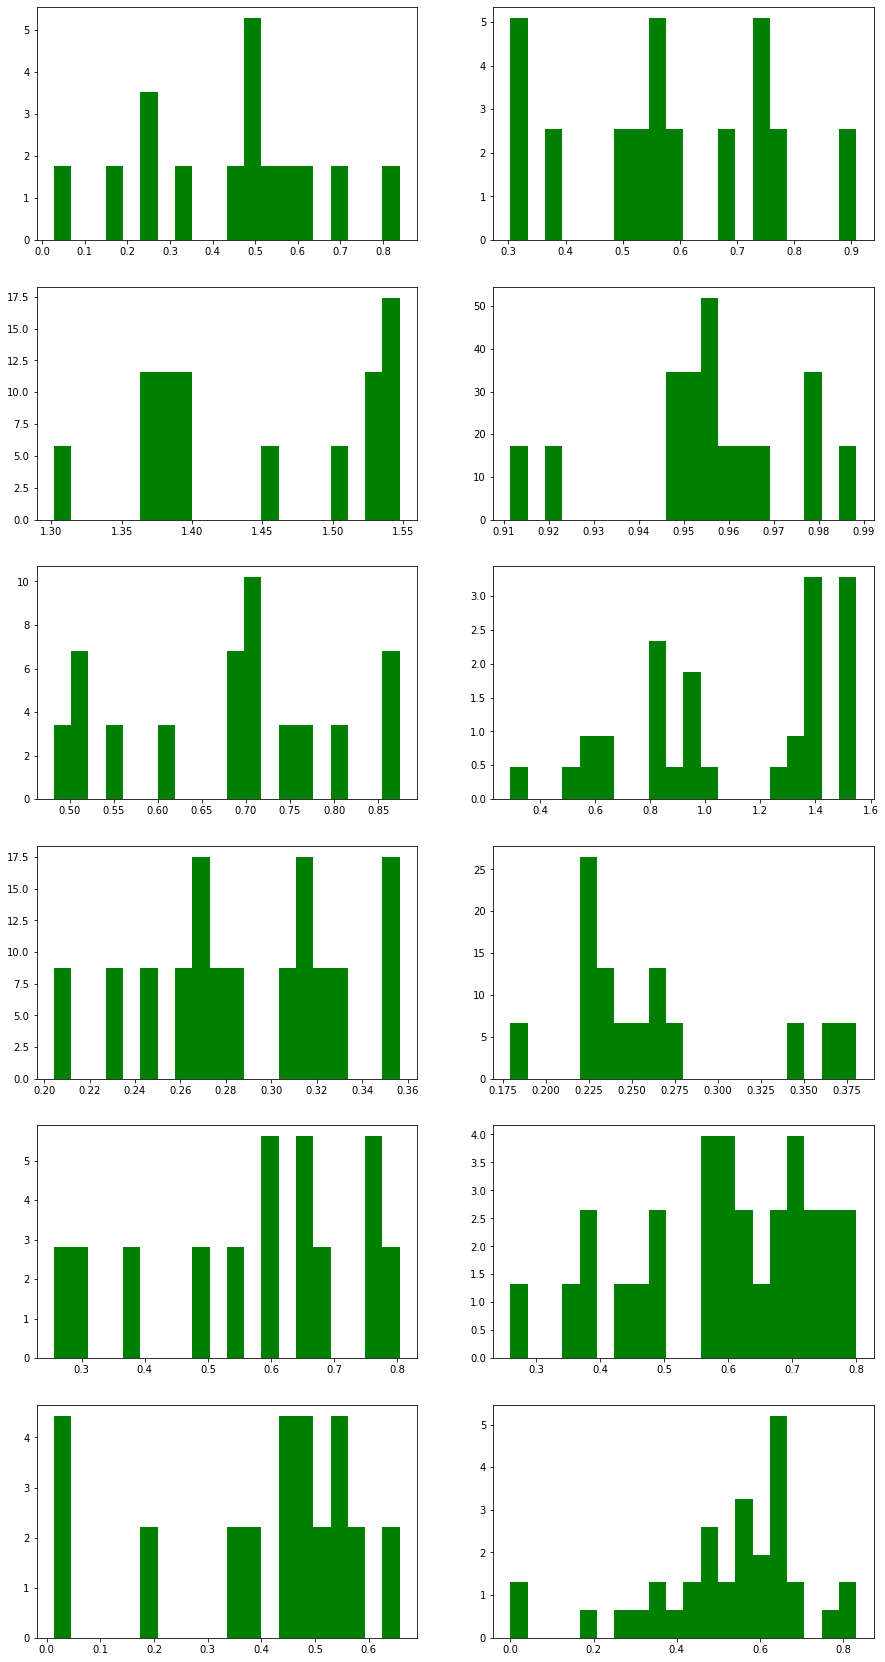

In [9]:
print("\t\t\t\t\t\tFeature B")
print("\t\t\tTest\t\t\t\t\t\t\tValidation")
plt.figure(figsize=(15,30))
#traffic[x]
idx=1
for x in traffic["test"]:
    trafficTest=traffic["test"][x]
    plt.subplot(6, 2, idx)
    plt.hist(trafficTest[:, featureB], 20, density=1, color='g')
    idx+=2

idx=2
for x in traffic["validation"]:
    trafficValidation=traffic["validation"][x]
    plt.subplot(6, 2, idx)
    plt.hist(trafficValidation[:, featureB], 20, density=1, color='g')
    idx+=2

### One-Class SVM

In [10]:
Xtrain=traffic["train"]["normal"]
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
clf.fit(Xtrain)

OneClassSVM(gamma='auto', nu=0.001)

In [11]:

print(clf.predict(Xtrain))

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1]


In [12]:
def scores(prediction, botWindow):
    TP=0.00001
    FP=0.00001
    FN=0.00001
    pIndex=0
    for p in prediction:
        if pIndex in botWindow:
            if p == -1:
                TP+=1
            else:
                FN+=1
        else:
            if p == -1:
                FP+=1
            else:
                TP+=1
        pIndex+=1
    try:
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1=2*((precision*recall)/(precision+recall))
    except:
        return None, None, None
    return precision, recall, f1

In [13]:
def process(dataInput, botWindow, algorithm="svm"):
    data=np.loadtxt(dataInput,dtype=int)
    traffic = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex)[window]
    name=dataInput.split("/")[1:3]
    showChart(dataInput)
    
    if algorithm == "svm":
        prediction = clf.predict(traffic)
    elif algorithm == "kmeans":
        prediction=[]
        for obs in traffic:
            dists = euclidean_distances([obs],kmeans.cluster_centers_)
            if dists[0]>maxDst+thresholdKmeans:
                prediction+=[-1]
            else:
                prediction+=[1]
    elif algorithm == "pca_svm":
        pcaFeatures = pca.fit(traffic).transform(traffic)
        prediction = clf.predict(pcaFeatures)

    count=0
    numPositives=0
    pIndex=0
    countAlerts=0
    for value in prediction:
        if value == 1:
            numPositives+=1
            if numPositives >= 2:
                count=0
                numPositives=0
        else:
            count+=1
        if count>=minimumAlert:
            countAlerts+=1
        pIndex+=1
    precision, recall, f1=scores(prediction,botWindow)
    
    if latex:
        print("& &", round(precision, 2), "&", round(recall, 2), "&", round(f1, 2), "&", countAlerts)
    else:  
        print("Traffic from", name[0], "in", name[1], "mode")
        print(prediction)
        print("Scores:")
        print(name[0], "in", name[1], "mode", "Precision:", round(precision, 2), "Recall:", round(recall, 2), "F1-Score:", round(f1, 2), "Alert (%):", countAlerts/(pIndex-minimumAlert+1)*100)
        print("Num Alerts:", countAlerts)
        print("Alert (%):", countAlerts/(pIndex-minimumAlert+1)*100)
        print("\n\n")
    

### Validation Data Set

Traffic from validation in normal.txt mode


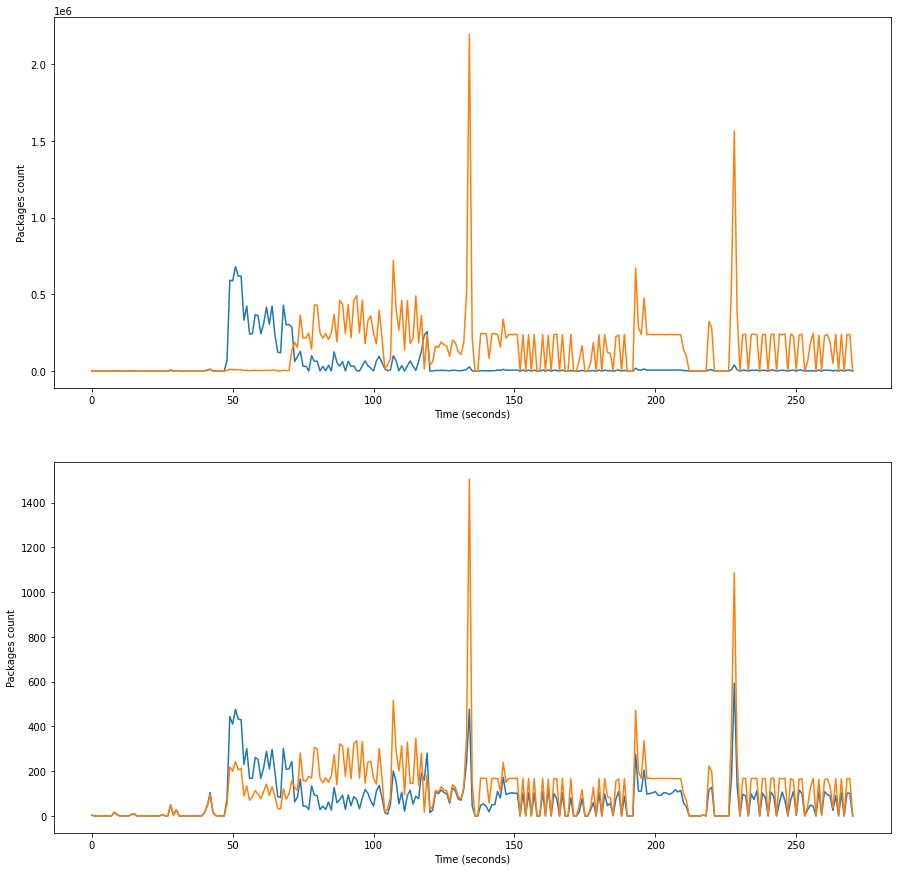

Traffic from validation in normal.txt mode
[ 1 -1  1 -1 -1 -1  1  1  1  1  1  1  1]
Scores:
validation in normal.txt mode Precision: 0.69 Recall: 1.0 F1-Score: 0.82 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in brute_isolated.txt mode


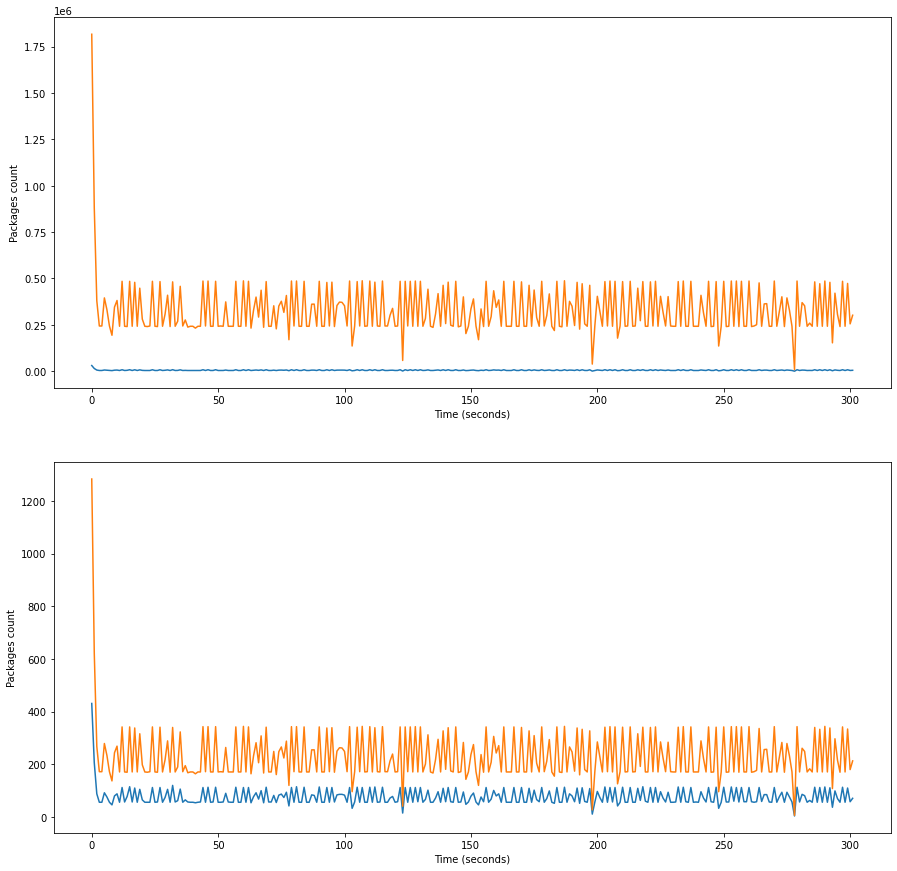

Traffic from validation in brute_isolated.txt mode
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Scores:
validation in brute_isolated.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 100.0
Num Alerts: 11
Alert (%): 100.0



Traffic from validation in brute_mixed.txt mode


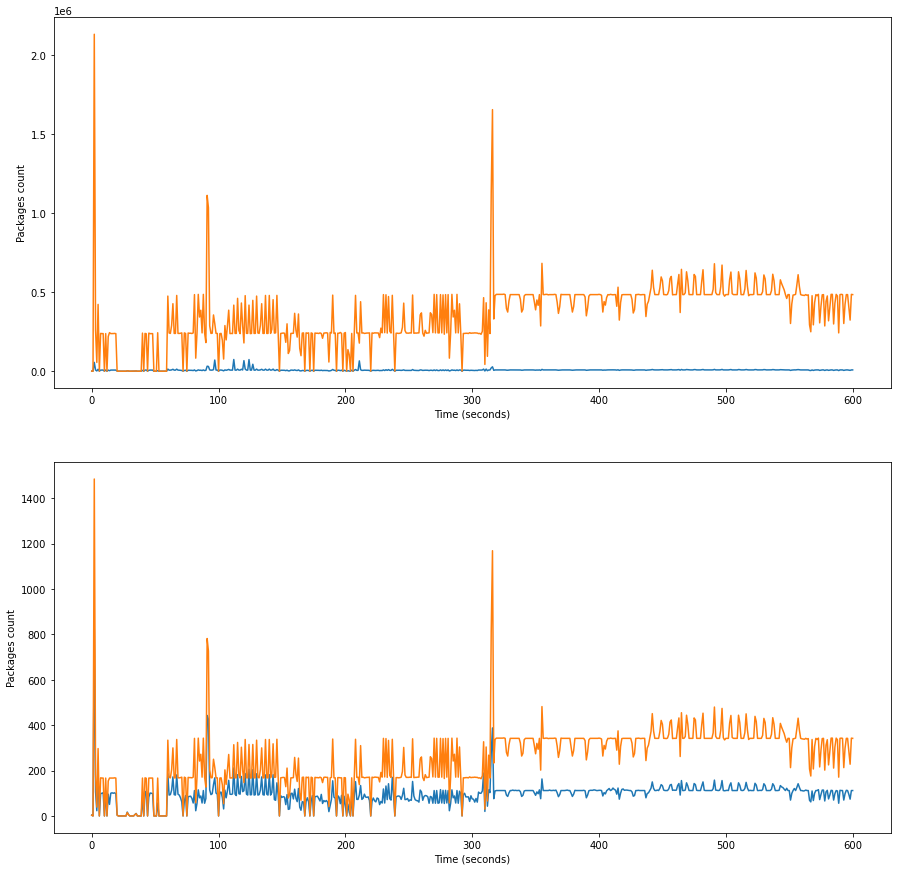

Traffic from validation in brute_mixed.txt mode
[ 1  1  1  1  1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Scores:
validation in brute_mixed.txt mode Precision: 1.0 Recall: 0.74 F1-Score: 0.85 Alert (%): 56.666666666666664
Num Alerts: 17
Alert (%): 56.666666666666664



Traffic from validation in smooth_isolated.txt mode


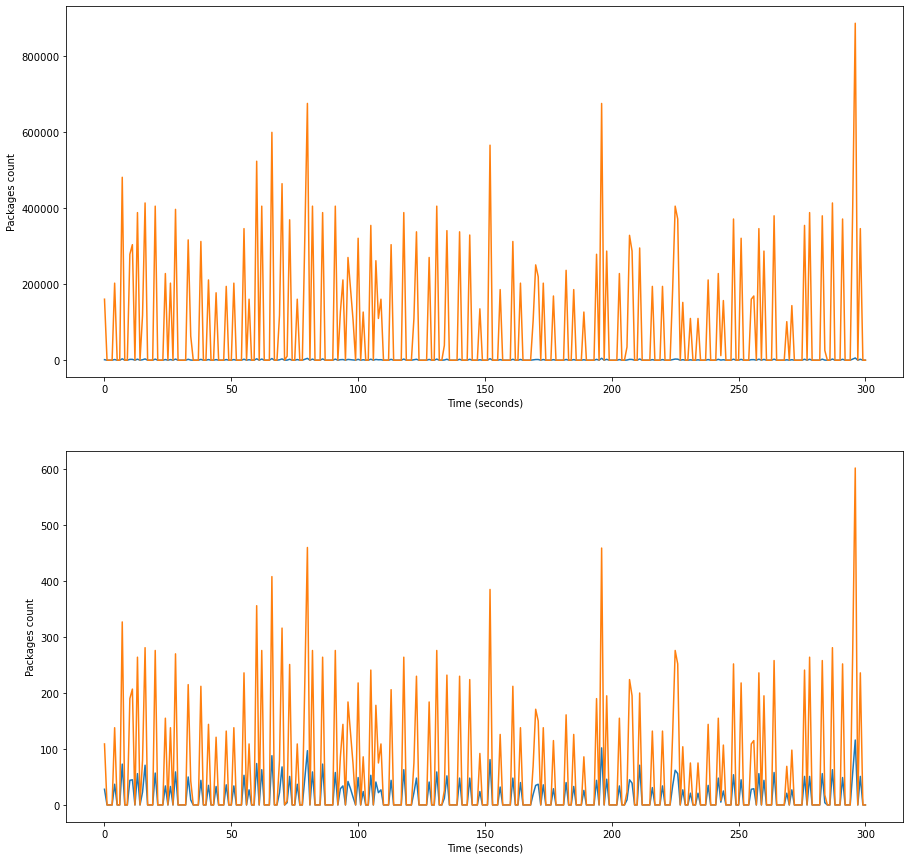

Traffic from validation in smooth_isolated.txt mode
[-1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1]
Scores:
validation in smooth_isolated.txt mode Precision: 1.0 Recall: 0.67 F1-Score: 0.8 Alert (%): 18.181818181818183
Num Alerts: 2
Alert (%): 18.181818181818183



Traffic from validation in smooth_mixed.txt mode


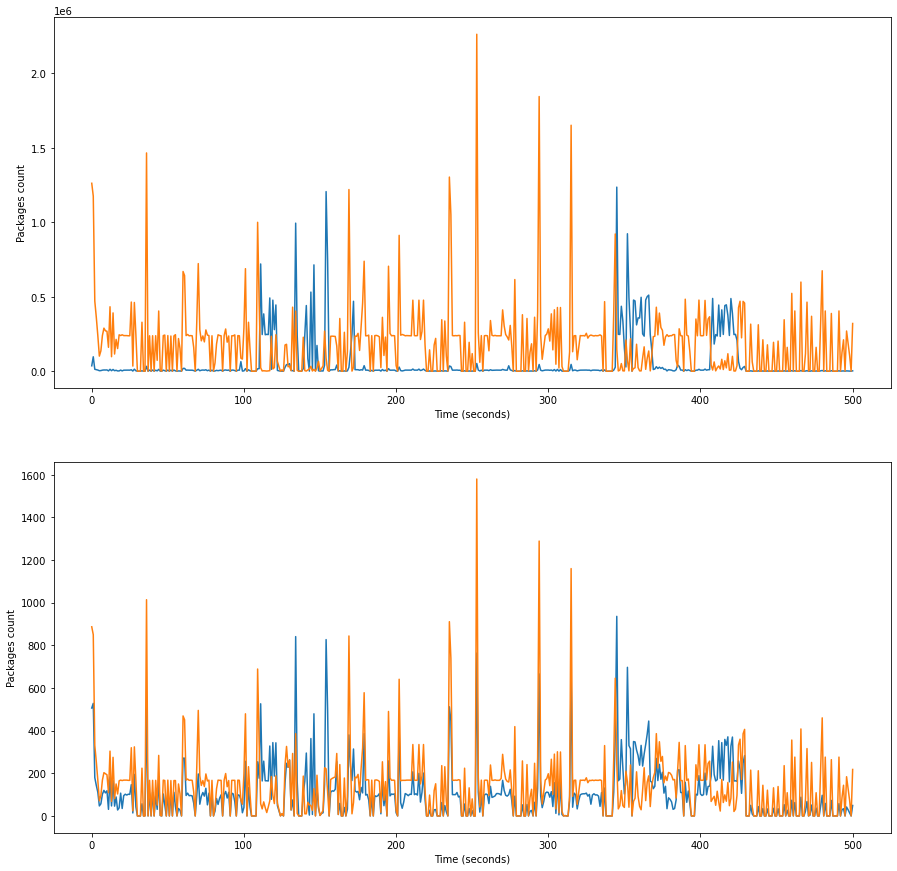

Traffic from validation in smooth_mixed.txt mode
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1]
Scores:
validation in smooth_mixed.txt mode Precision: 1.0 Recall: 0.14 F1-Score: 0.25 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in intelligent.txt mode


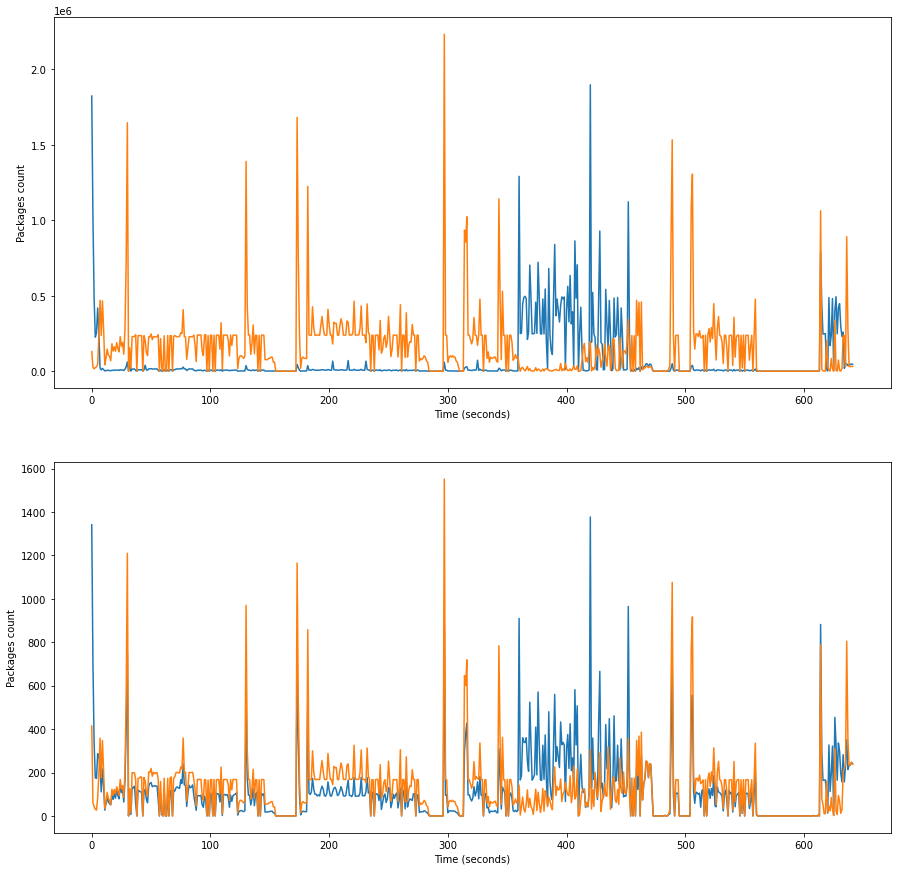

Traffic from validation in intelligent.txt mode
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1  1  1  1  1  1  1  1  1 -1 -1 -1 -1]
Scores:
validation in intelligent.txt mode Precision: 1.0 Recall: 0.43 F1-Score: 0.6 Alert (%): 3.0303030303030303
Num Alerts: 1
Alert (%): 3.0303030303030303





In [14]:
valFiles=[(datasets["validation"]["normal"], [-1]), 
            (datasets["validation"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in valFiles:
    process(dataInput, botWin, "svm")

### Test Data Set

Traffic from test in normal.txt mode


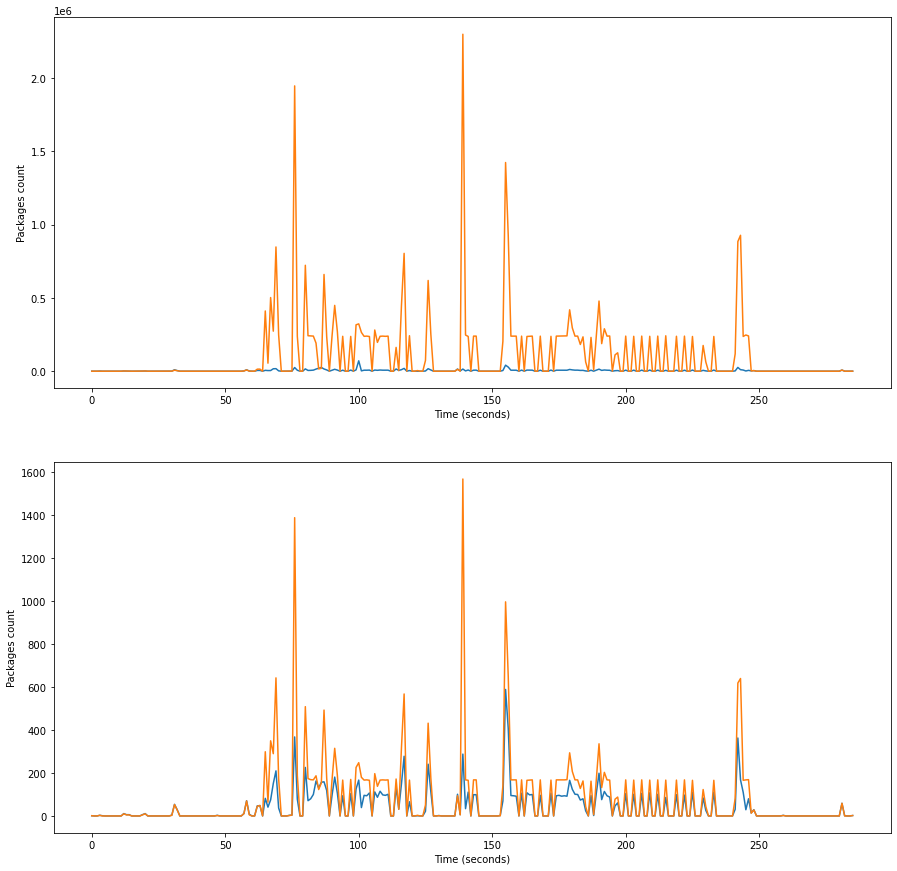

Traffic from test in normal.txt mode
[-1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Scores:
test in normal.txt mode Precision: 0.93 Recall: 1.0 F1-Score: 0.96 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in brute_isolated.txt mode


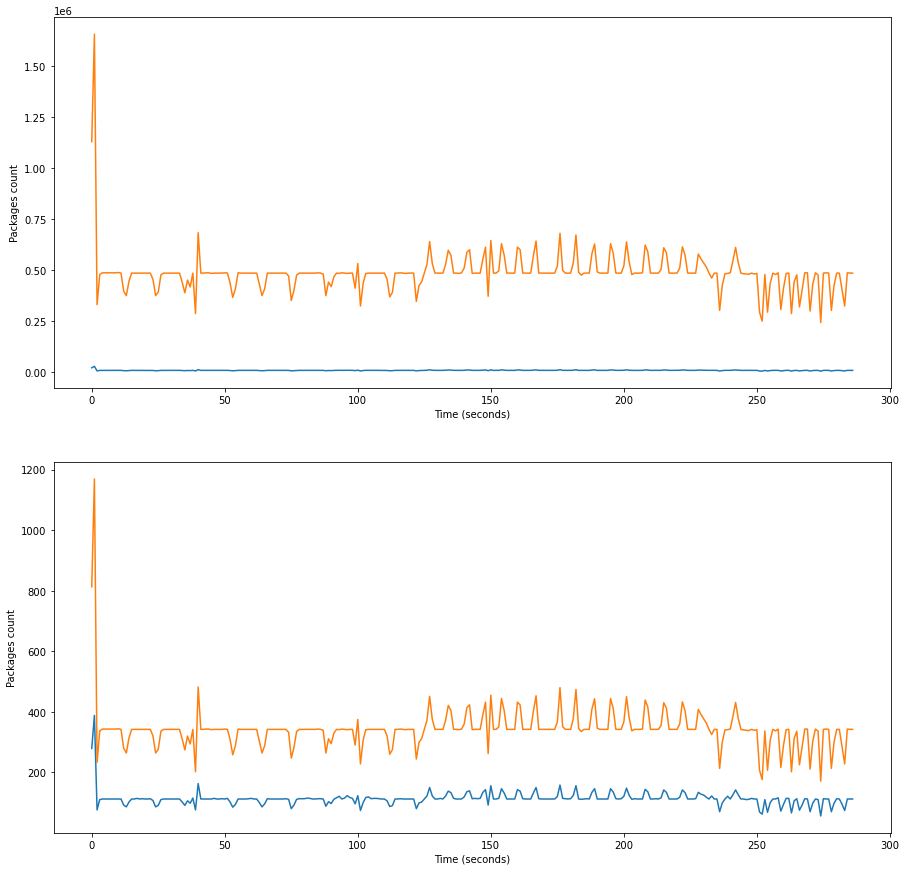

Traffic from test in brute_isolated.txt mode
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Scores:
test in brute_isolated.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 100.0
Num Alerts: 10
Alert (%): 100.0



Traffic from test in brute_mixed.txt mode


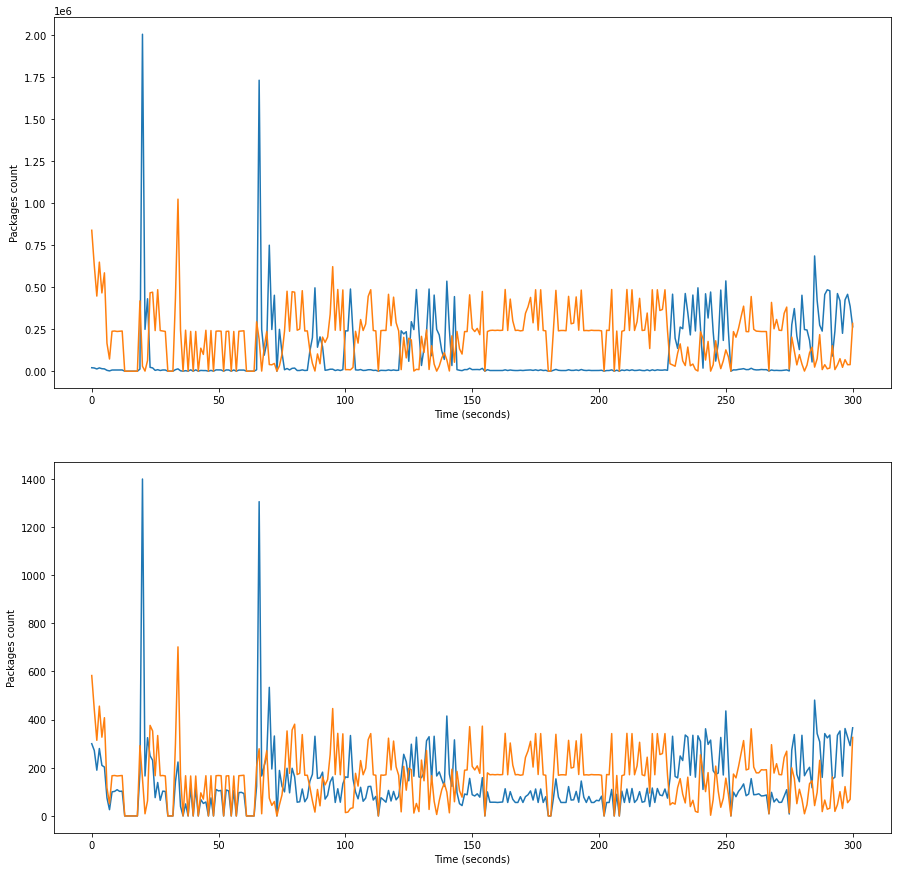

Traffic from test in brute_mixed.txt mode
[ 1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1]
Scores:
test in brute_mixed.txt mode Precision: 1.0 Recall: 0.33 F1-Score: 0.5 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in smooth_isolated.txt mode


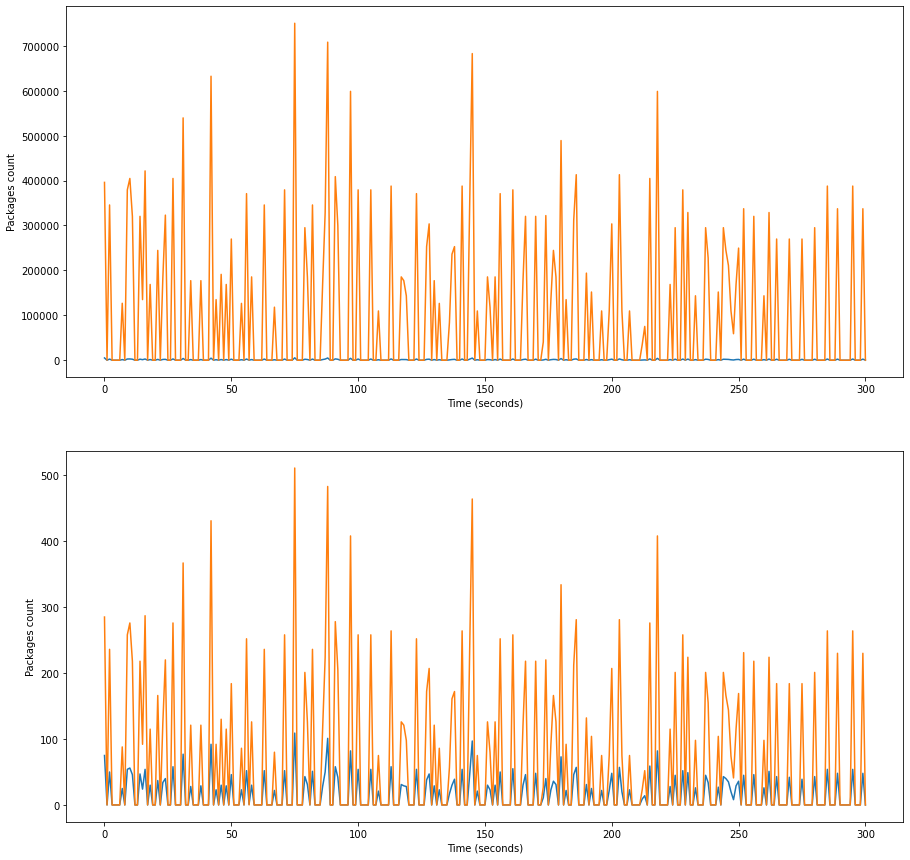

Traffic from test in smooth_isolated.txt mode
[-1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1]
Scores:
test in smooth_isolated.txt mode Precision: 1.0 Recall: 0.6 F1-Score: 0.75 Alert (%): 36.36363636363637
Num Alerts: 4
Alert (%): 36.36363636363637



Traffic from test in smooth_mixed.txt mode


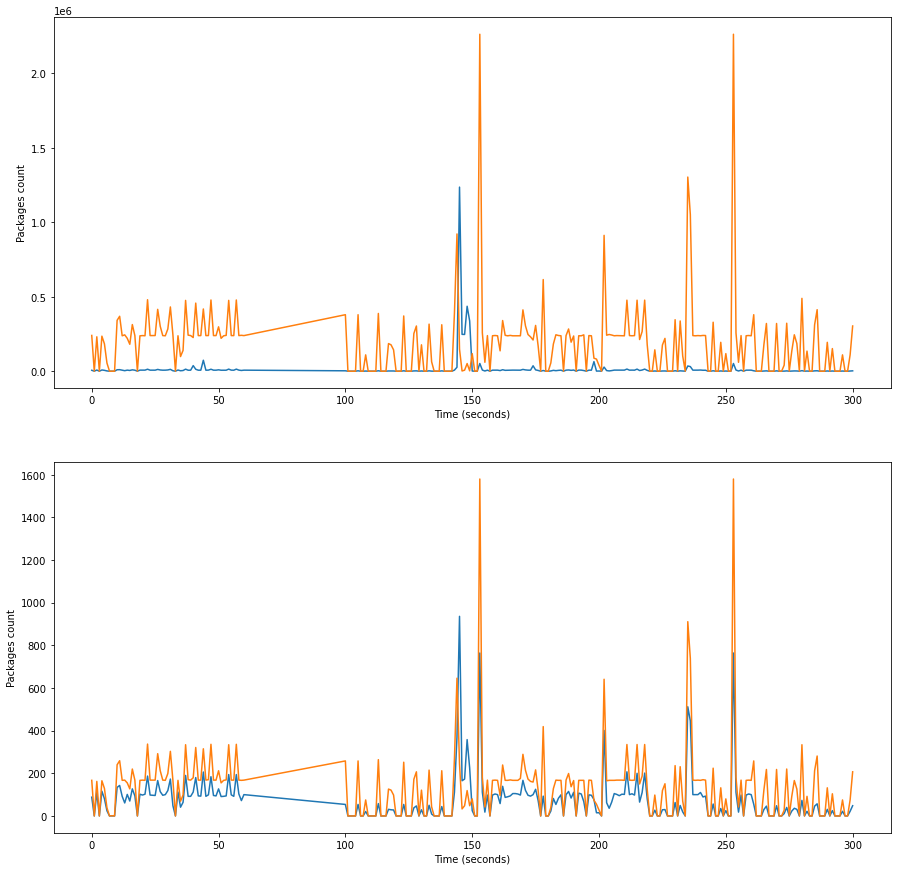

Traffic from test in smooth_mixed.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in smooth_mixed.txt mode Precision: 1.0 Recall: 0.23 F1-Score: 0.38 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in intelligent.txt mode


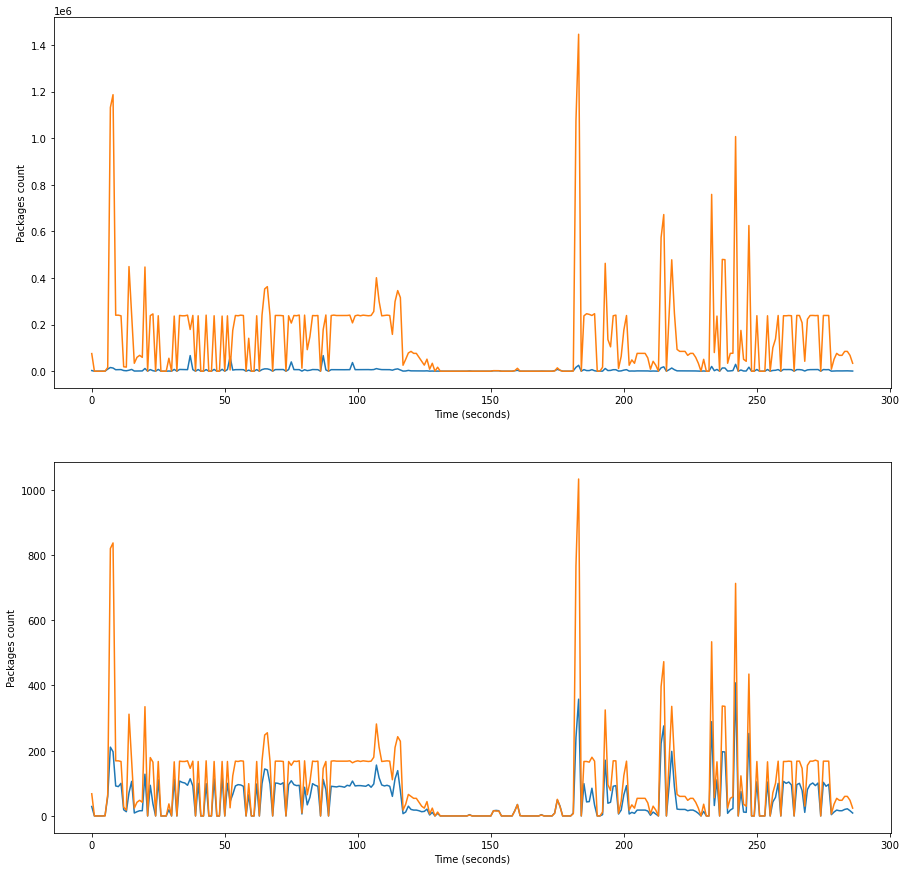

Traffic from test in intelligent.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in intelligent.txt mode Precision: 1.0 Recall: 0.21 F1-Score: 0.35 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0





In [15]:
testFiles=[(datasets["test"]["normal"], [-1]), 
            (datasets["test"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in testFiles:
    process(dataInput, botWin, "svm")

### K-Means

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

kmeans = KMeans(n_clusters=1, random_state=0).fit(Xtrain)
print(kmeans.cluster_centers_[0])
#dists = euclidean_distances(kmeans.cluster_centers_)

maxDst=0
for obs in Xtrain:
    dists = euclidean_distances([obs],kmeans.cluster_centers_)
    if dists[0]>maxDst:
        maxDst=dists[0]
thresholdKmeans=maxDst*0.2

[0.17447553 0.4114031  0.47764827 0.5381942  0.10155107 0.41542431
 0.43900036 0.55131881 0.22181069 0.35891877 0.37403391 0.39583336
 0.22542595 0.14278547 0.12984385 0.21756225 0.15305082 0.1367825
 0.28863796 0.30529019 0.34382967 0.28016937 0.31514052 0.33513985
 0.22036476 0.46966913 0.56692548 0.6394573  0.06723988 0.49463442
 0.4497392  0.58794779 0.2882053  0.4857376  0.48604423 0.50711888
 0.35671883 0.33521378 0.25878368 0.34430653 0.34398104 0.27430199
 0.39179708 0.32466331 0.28324961 0.37938478 0.3350758  0.28451993]


### Validation Data Set

Traffic from validation in normal.txt mode


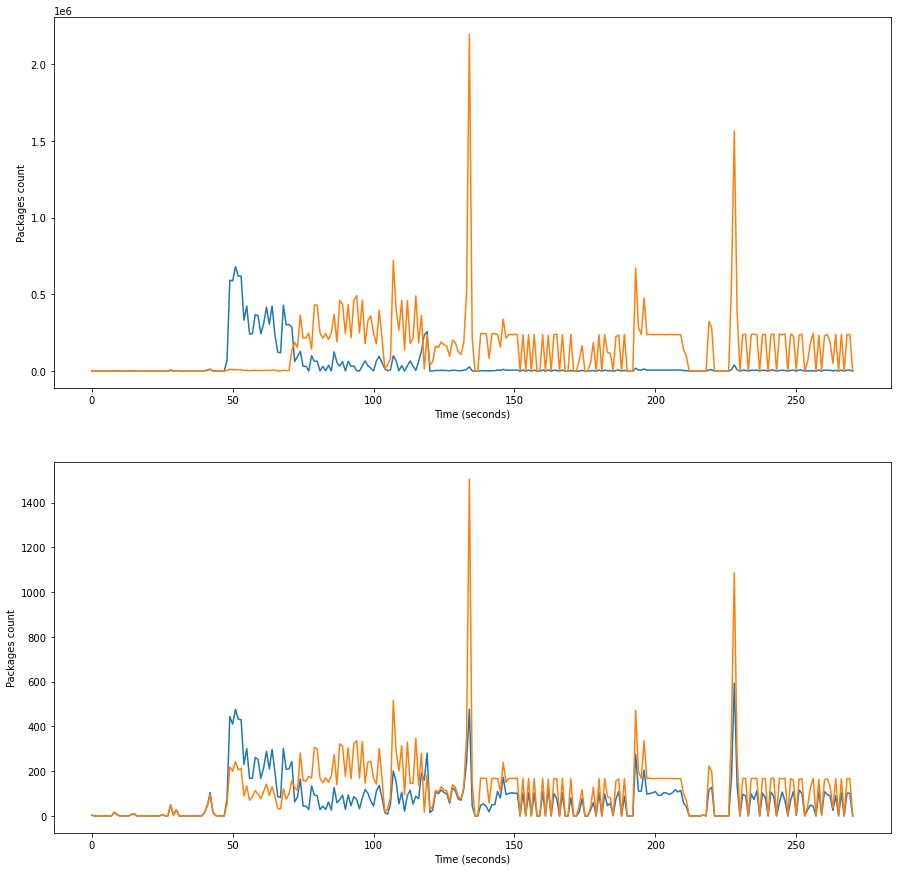

Traffic from validation in normal.txt mode
[1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
validation in normal.txt mode Precision: 0.85 Recall: 1.0 F1-Score: 0.92 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in brute_isolated.txt mode


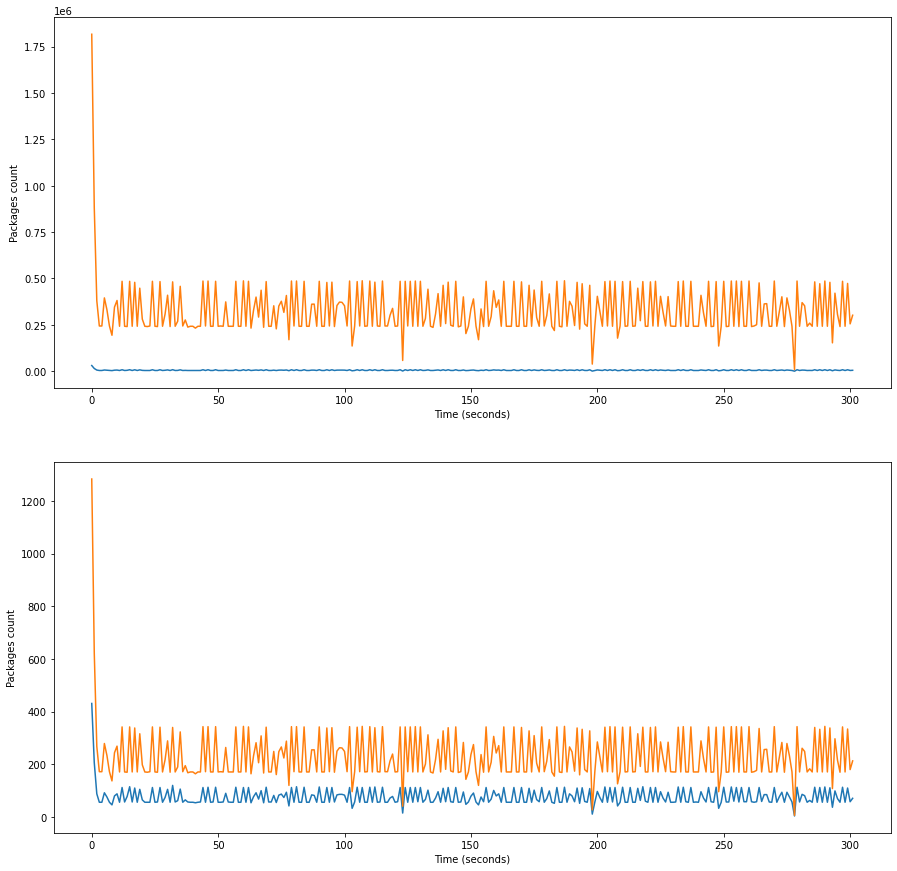

Traffic from validation in brute_isolated.txt mode
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Scores:
validation in brute_isolated.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 100.0
Num Alerts: 11
Alert (%): 100.0



Traffic from validation in brute_mixed.txt mode


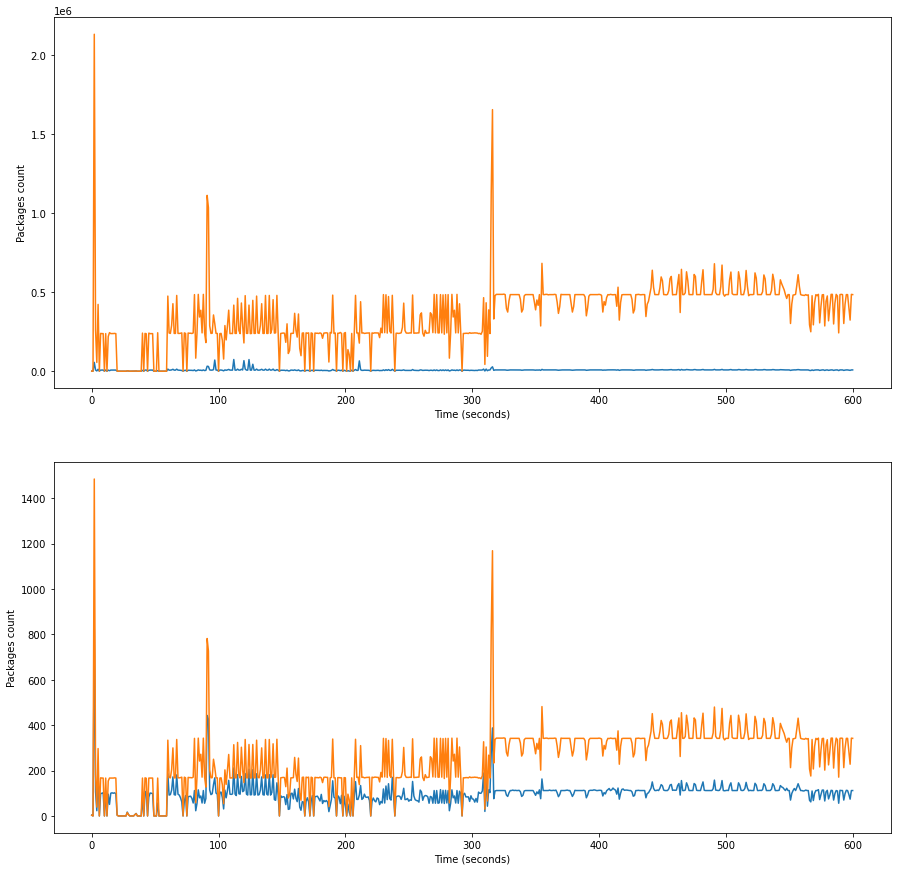

Traffic from validation in brute_mixed.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Scores:
validation in brute_mixed.txt mode Precision: 1.0 Recall: 0.59 F1-Score: 0.74 Alert (%): 43.333333333333336
Num Alerts: 13
Alert (%): 43.333333333333336



Traffic from validation in smooth_isolated.txt mode


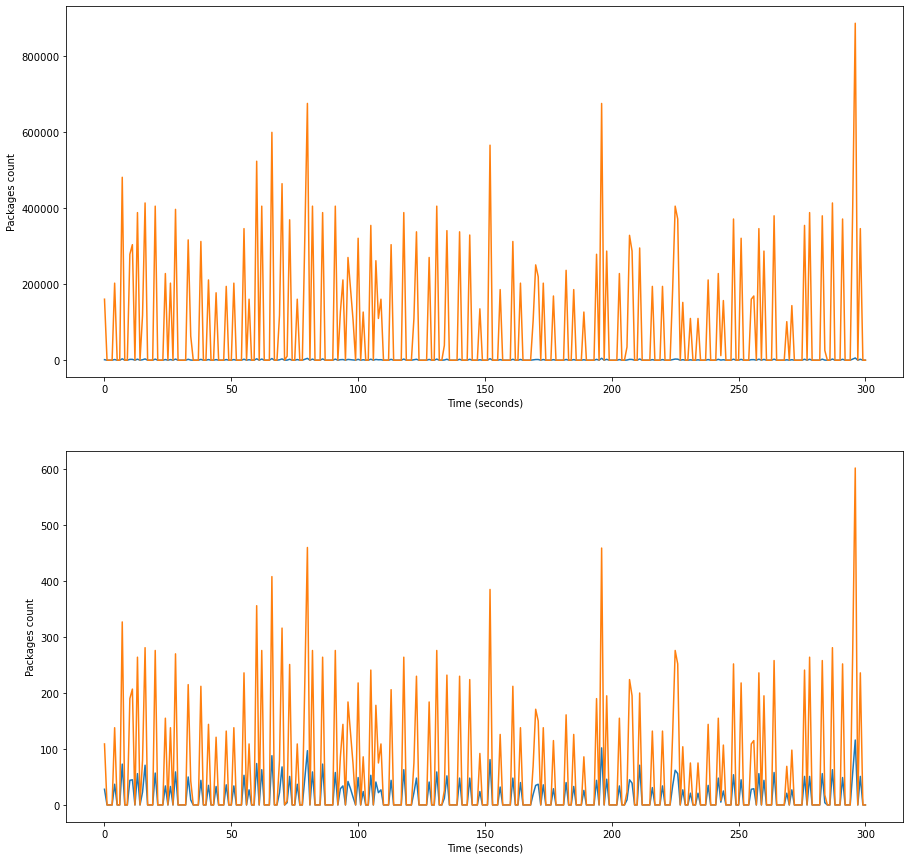

Traffic from validation in smooth_isolated.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
validation in smooth_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in smooth_mixed.txt mode


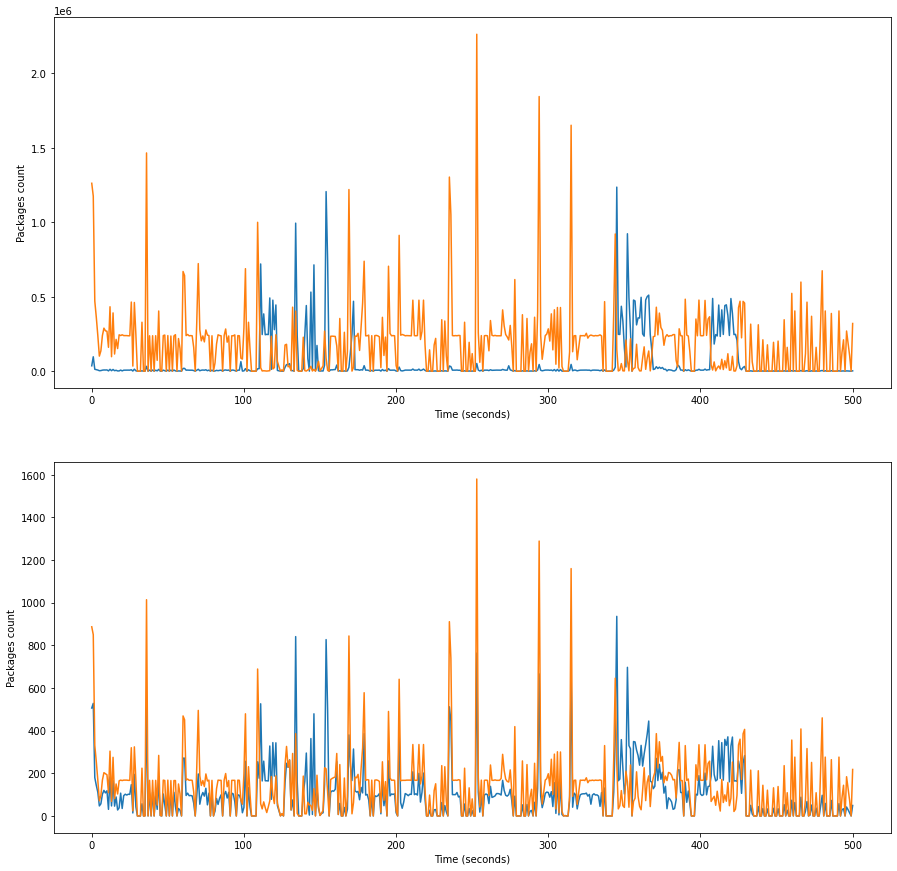

Traffic from validation in smooth_mixed.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
validation in smooth_mixed.txt mode Precision: 1.0 Recall: 0.11 F1-Score: 0.19 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in intelligent.txt mode


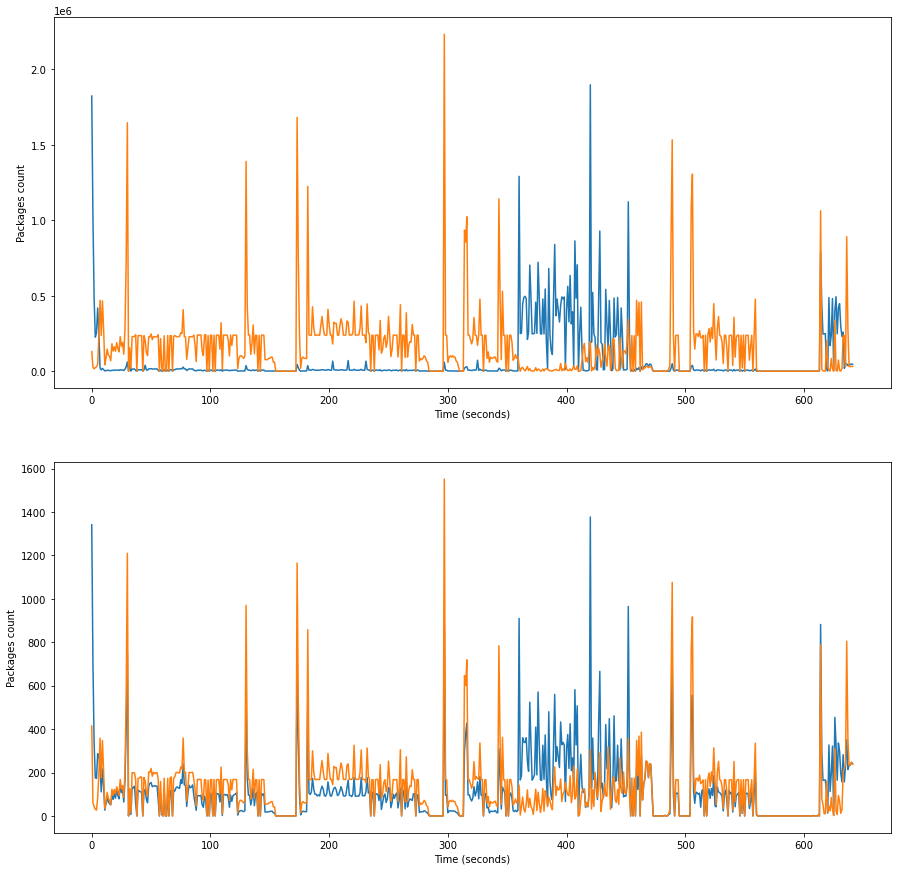

Traffic from validation in intelligent.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1]
Scores:
validation in intelligent.txt mode Precision: 1.0 Recall: 0.35 F1-Score: 0.52 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0





In [17]:
valFiles=[(datasets["validation"]["normal"], [-1]), 
            (datasets["validation"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in valFiles:
    process(dataInput, botWin, "kmeans")

### Test Data Set

Traffic from test in normal.txt mode


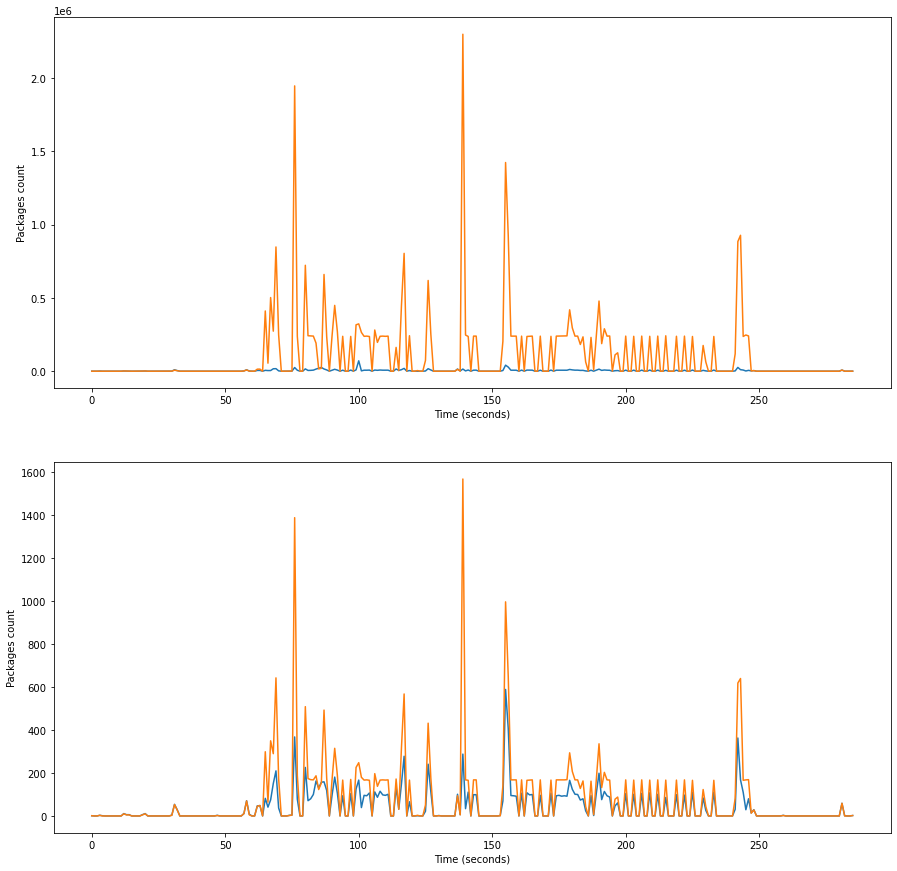

Traffic from test in normal.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
test in normal.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in brute_isolated.txt mode


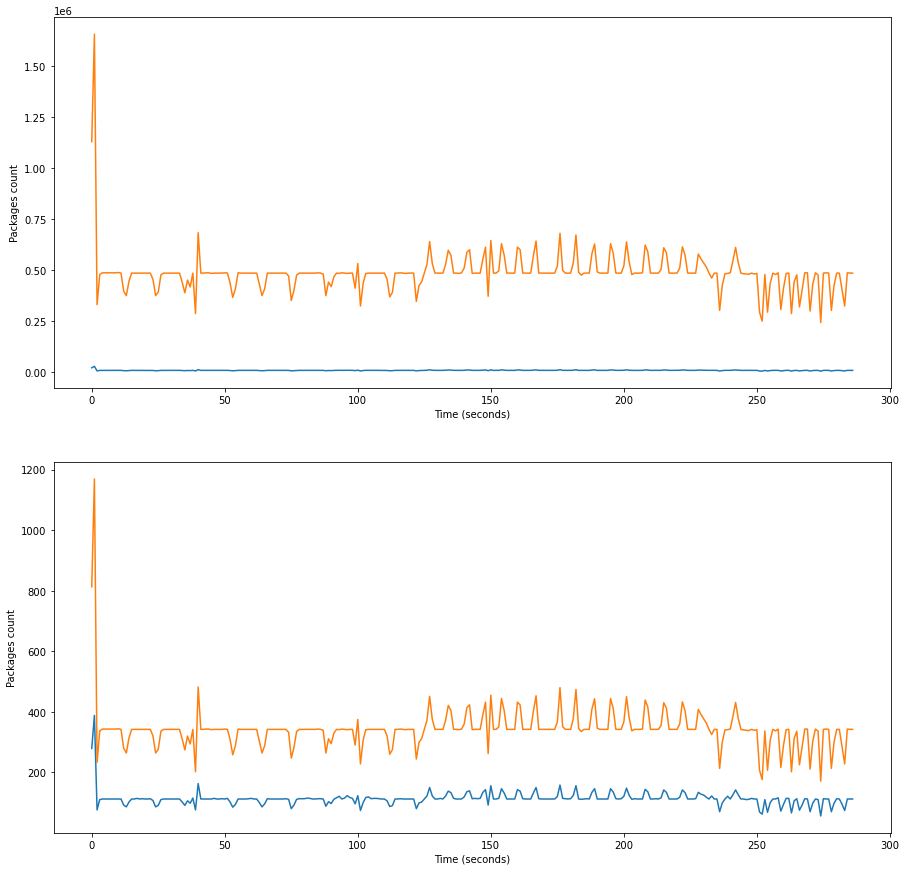

Traffic from test in brute_isolated.txt mode
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Scores:
test in brute_isolated.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 100.0
Num Alerts: 10
Alert (%): 100.0



Traffic from test in brute_mixed.txt mode


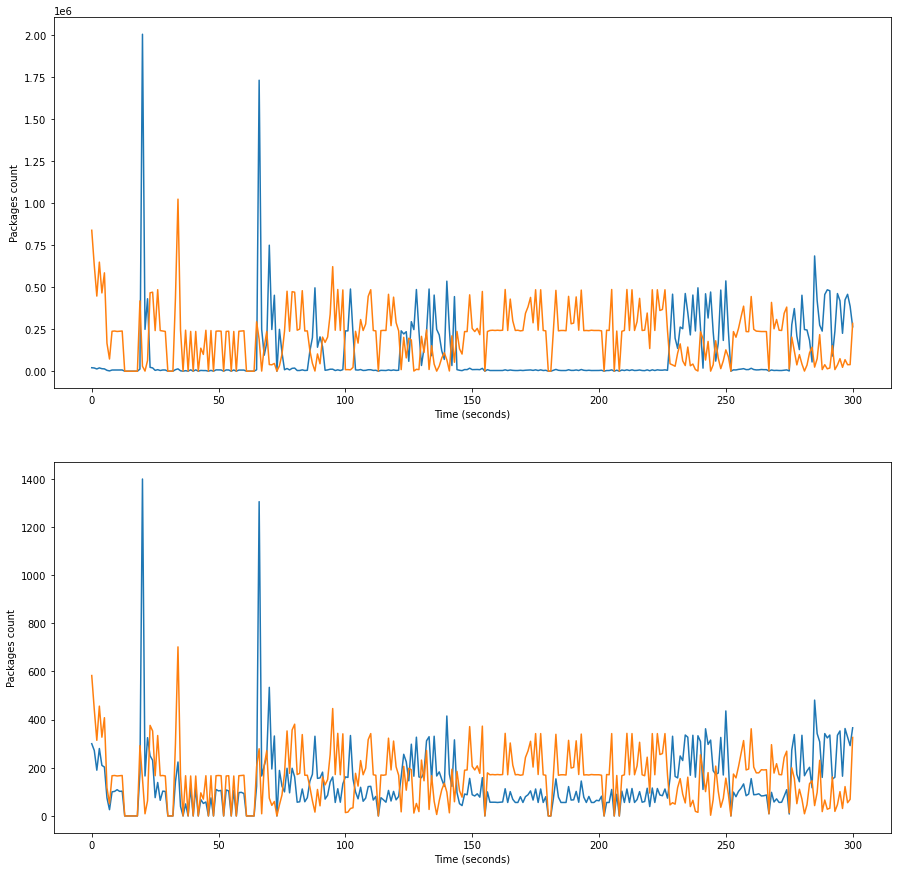

Traffic from test in brute_mixed.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
test in brute_mixed.txt mode Precision: 1.0 Recall: 0.2 F1-Score: 0.33 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in smooth_isolated.txt mode


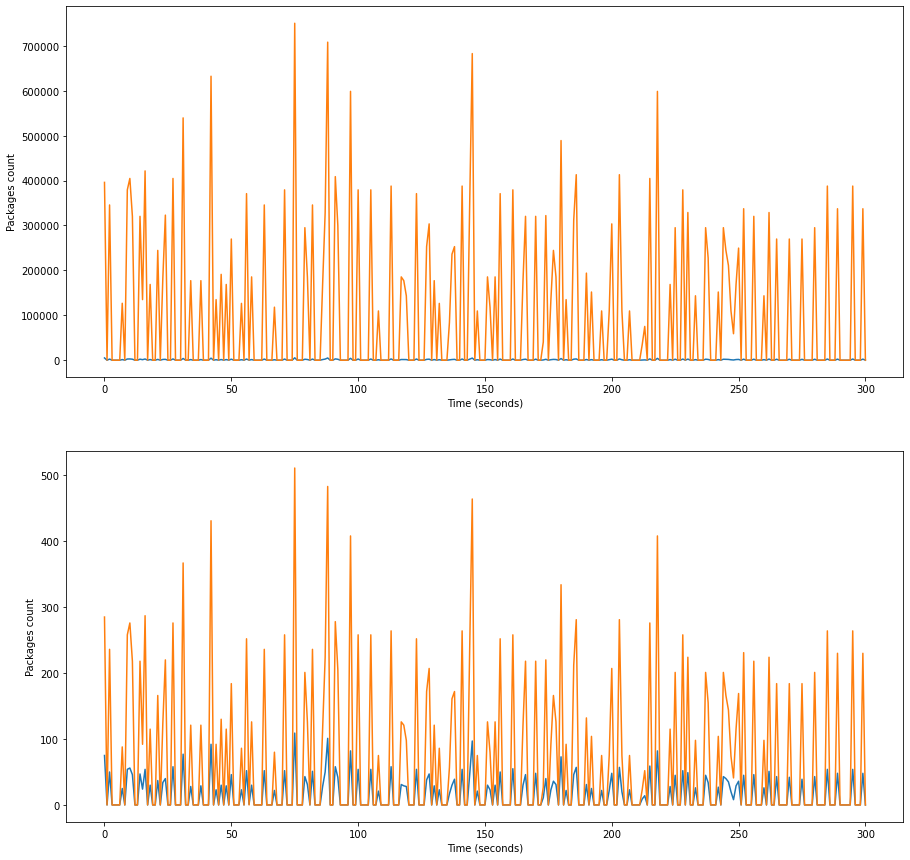

Traffic from test in smooth_isolated.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
test in smooth_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in smooth_mixed.txt mode


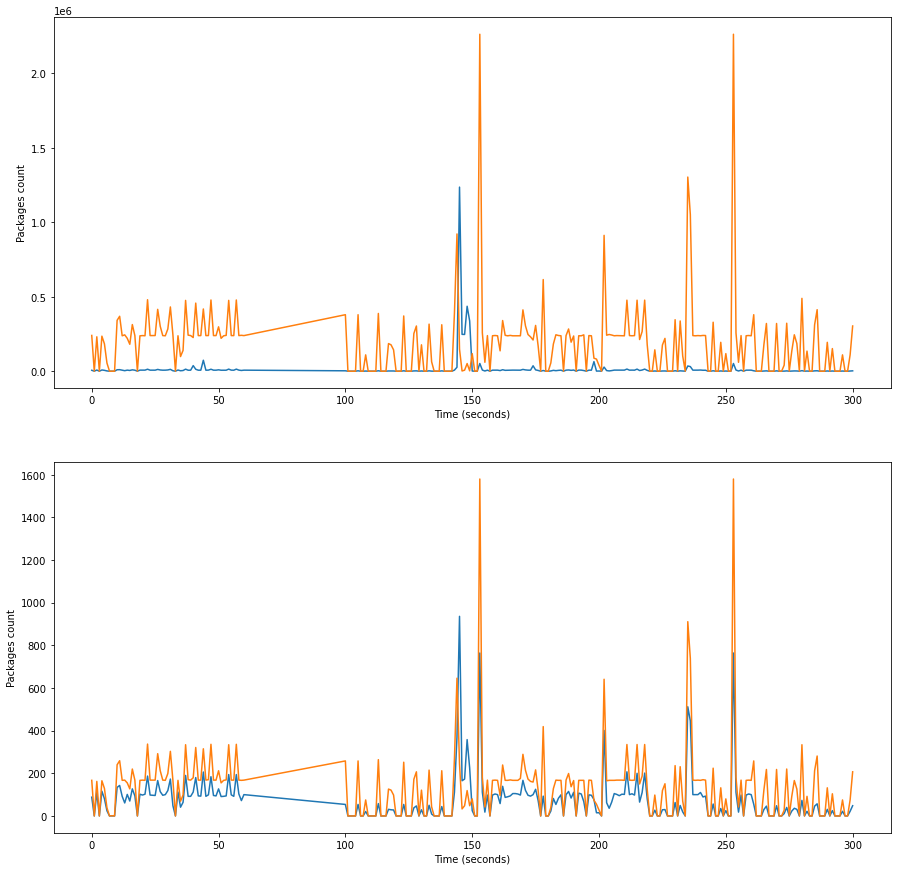

Traffic from test in smooth_mixed.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
test in smooth_mixed.txt mode Precision: 1.0 Recall: 0.23 F1-Score: 0.38 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in intelligent.txt mode


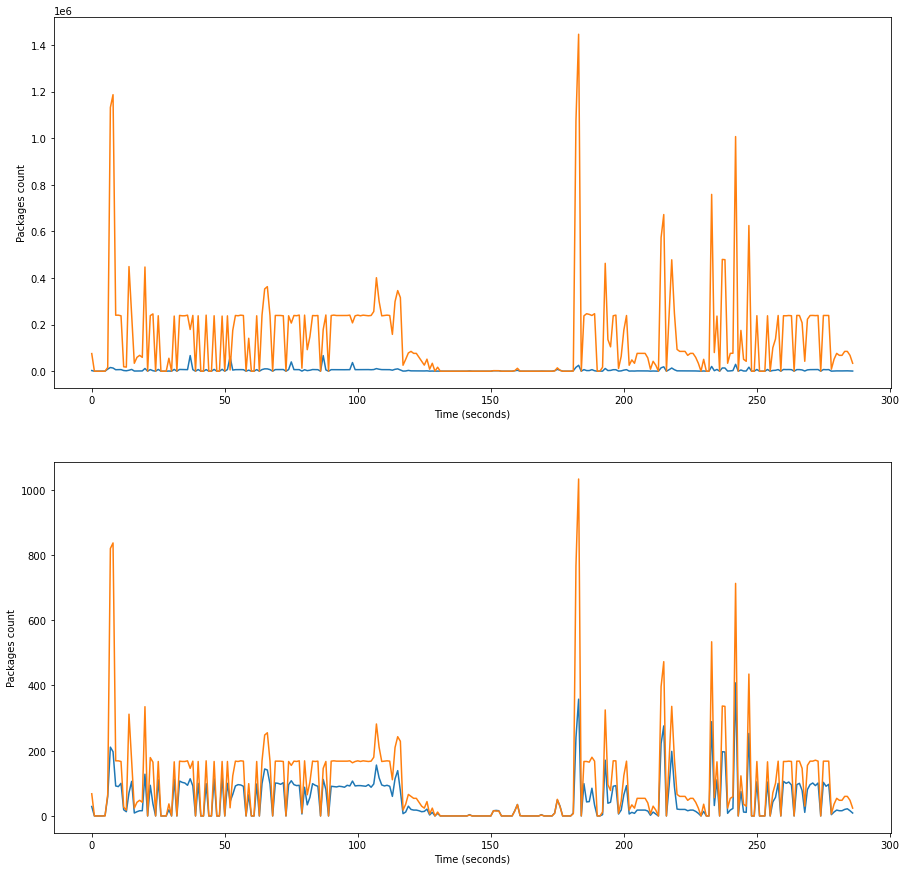

Traffic from test in intelligent.txt mode
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Scores:
test in intelligent.txt mode Precision: 1.0 Recall: 0.21 F1-Score: 0.35 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0





In [18]:
testFiles=[(datasets["test"]["normal"], [-1]), 
            (datasets["test"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in testFiles:
    process(dataInput, botWin, "kmeans")

### Feature Refining

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12, svd_solver='full')
pcaFeatures = pca.fit(Xtrain).transform(Xtrain)
pcaFeatures

#plt.figure(8)
#plotFeatures(pcaFeatures,oClass,0,1)

array([[ 0.46683406,  1.41407581, -0.38238508, ..., -0.12107716,
         0.22406434,  0.07376269],
       [-0.40064601,  0.90547399, -0.11603079, ..., -0.28439545,
         0.09225335, -0.11861974],
       [-1.19291298,  0.32624408,  0.14246045, ..., -0.18478443,
         0.10386218,  0.26380669],
       ...,
       [-0.15719249,  0.64326238,  0.11330001, ..., -0.0414213 ,
        -0.09113097, -0.17142198],
       [ 0.18955591,  1.24819115,  0.40349943, ...,  0.11410841,
         0.03097766,  0.12569535],
       [ 0.59032376,  1.66921401,  1.16677444, ...,  0.3707924 ,
         0.06292831,  0.1144835 ]])

In [20]:
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
clf.fit(pcaFeatures)

OneClassSVM(gamma='auto', nu=0.001)

## One-Class SVM
### Validation Data Set

Traffic from validation in normal.txt mode


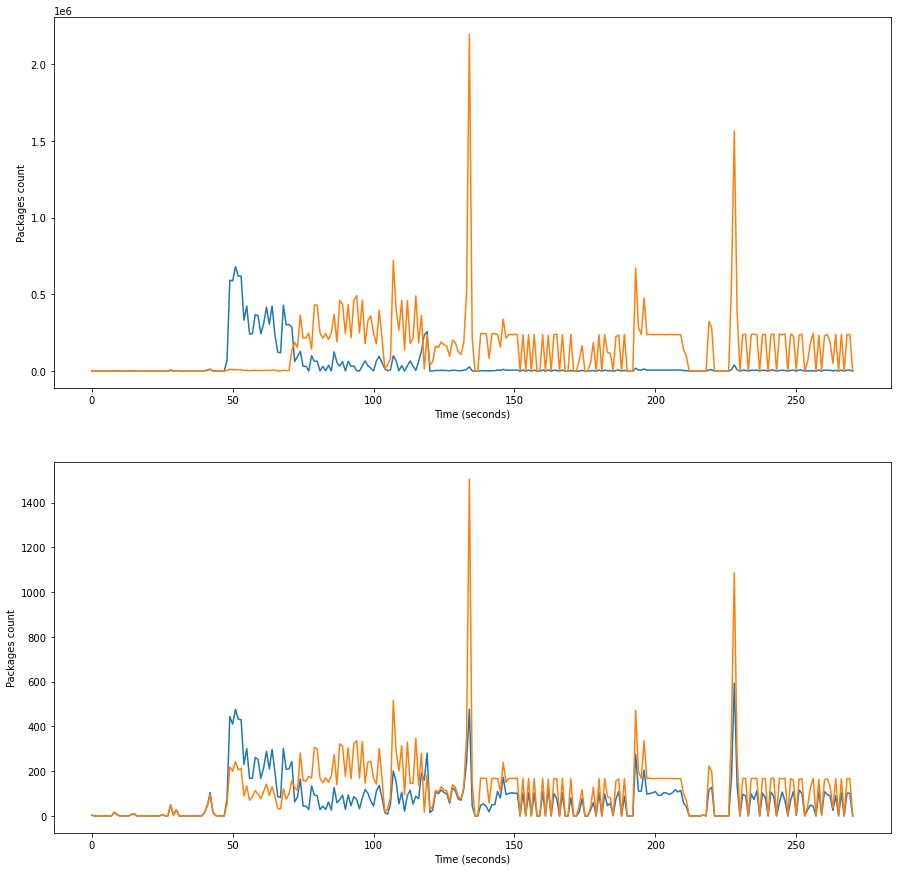

Traffic from validation in normal.txt mode
[-1 -1  1 -1 -1  1  1  1 -1  1  1  1  1]
Scores:
validation in normal.txt mode Precision: 0.62 Recall: 1.0 F1-Score: 0.76 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in brute_isolated.txt mode


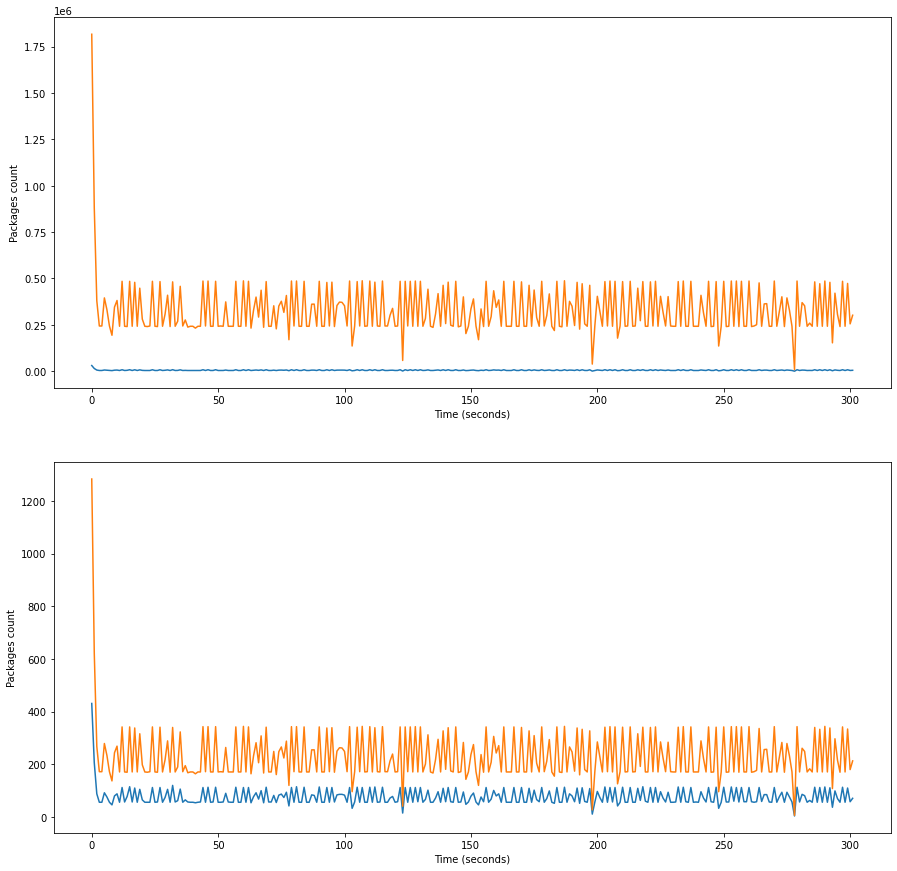

Traffic from validation in brute_isolated.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
validation in brute_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in brute_mixed.txt mode


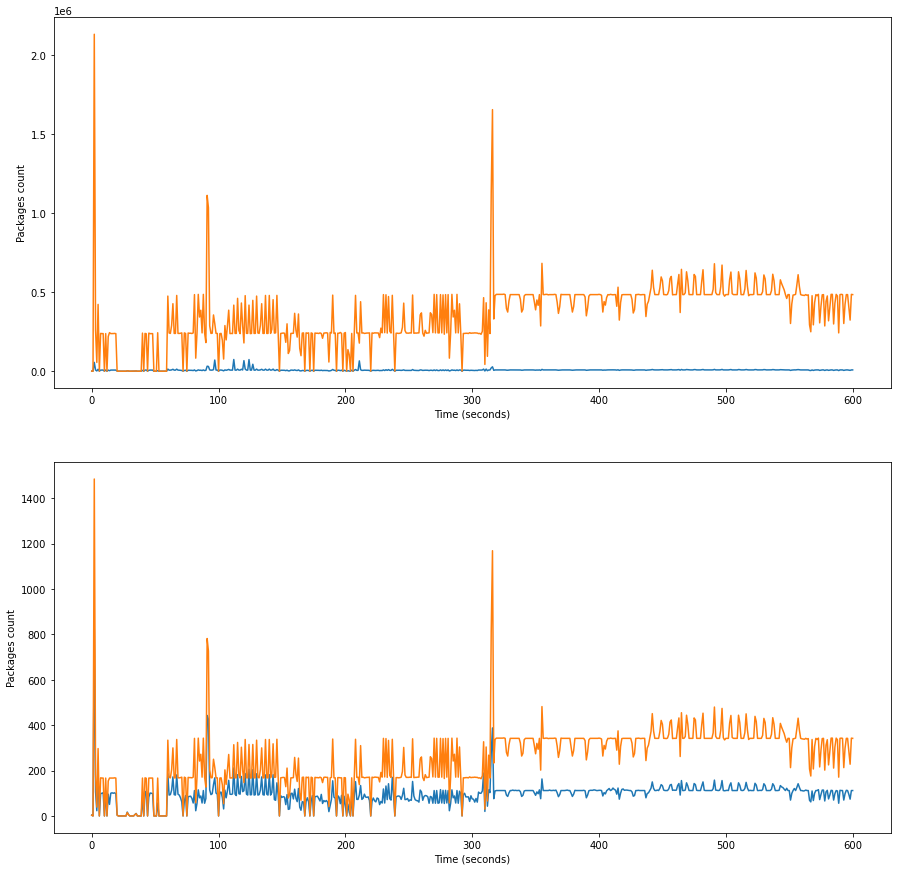

Traffic from validation in brute_mixed.txt mode
[-1 -1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Scores:
validation in brute_mixed.txt mode Precision: 0.85 Recall: 0.55 F1-Score: 0.67 Alert (%): 36.666666666666664
Num Alerts: 11
Alert (%): 36.666666666666664



Traffic from validation in smooth_isolated.txt mode


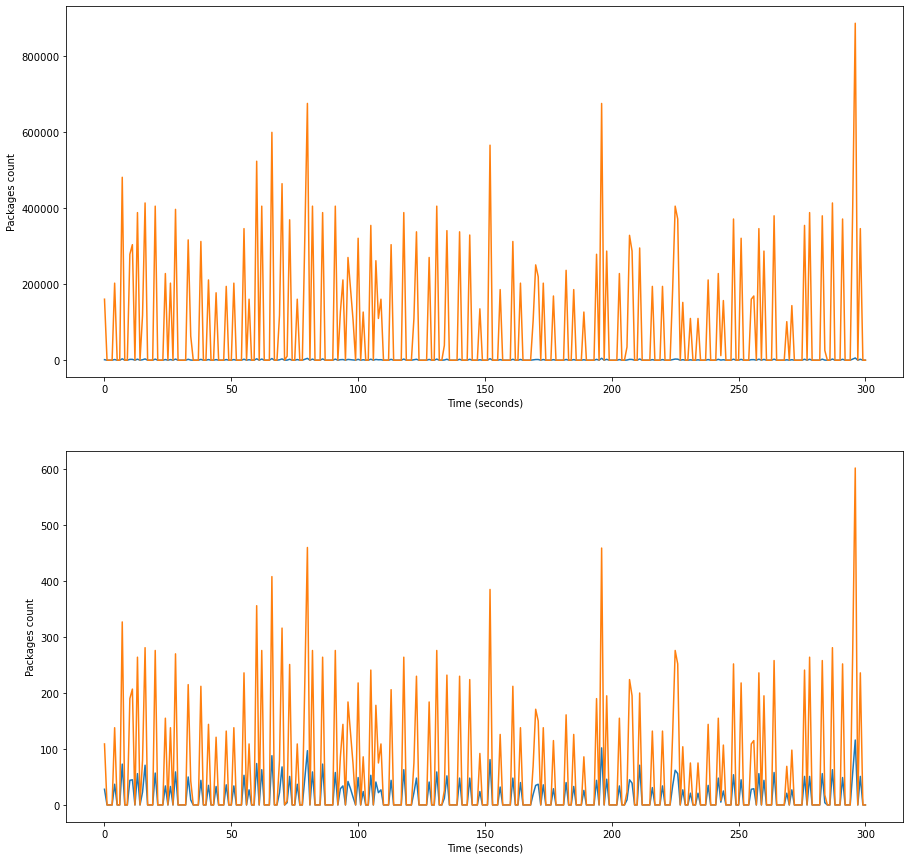

Traffic from validation in smooth_isolated.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
validation in smooth_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in smooth_mixed.txt mode


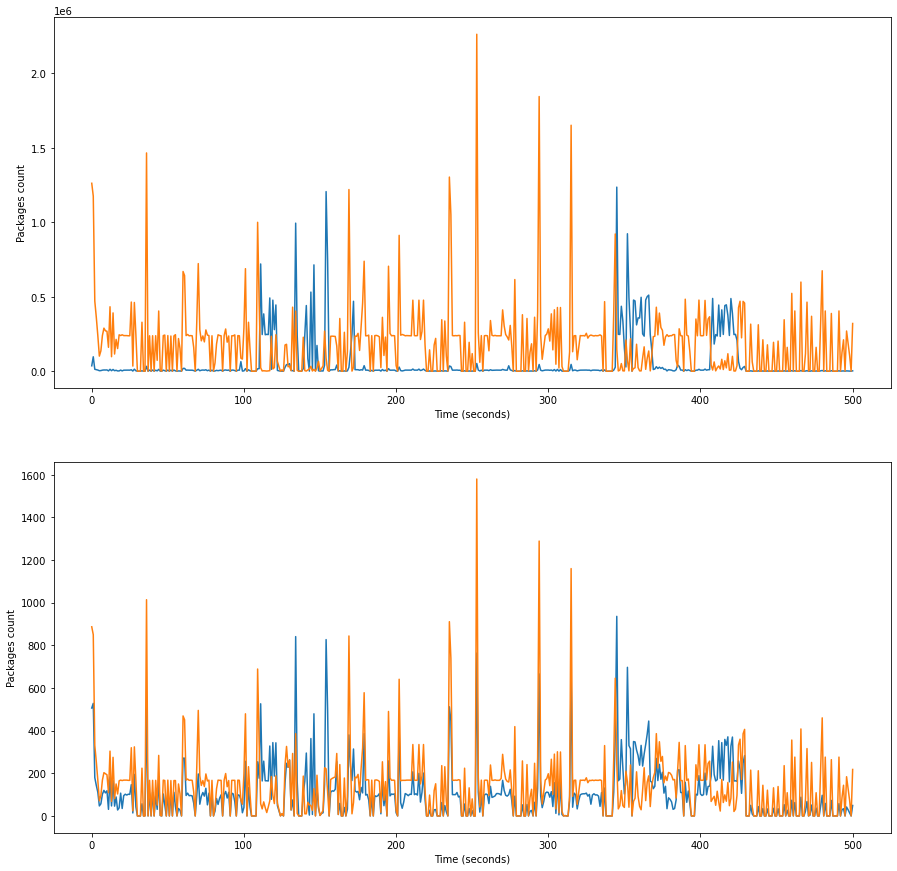

Traffic from validation in smooth_mixed.txt mode
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1  1 -1]
Scores:
validation in smooth_mixed.txt mode Precision: 1.0 Recall: 0.21 F1-Score: 0.35 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from validation in intelligent.txt mode


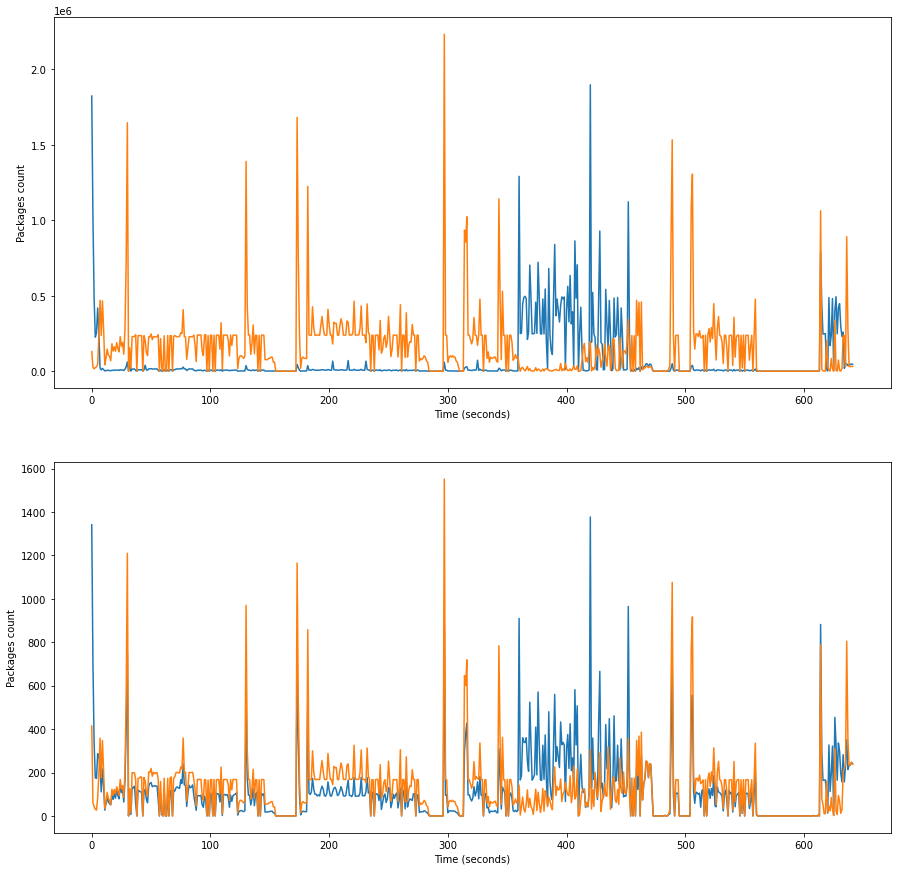

Traffic from validation in intelligent.txt mode
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1]
Scores:
validation in intelligent.txt mode Precision: 1.0 Recall: 0.43 F1-Score: 0.6 Alert (%): 6.0606060606060606
Num Alerts: 2
Alert (%): 6.0606060606060606





In [21]:
valFiles=[(datasets["validation"]["normal"], [-1]), 
            (datasets["validation"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in valFiles:
    process(dataInput, botWin, "pca_svm")

### Test Data Set

Traffic from test in normal.txt mode


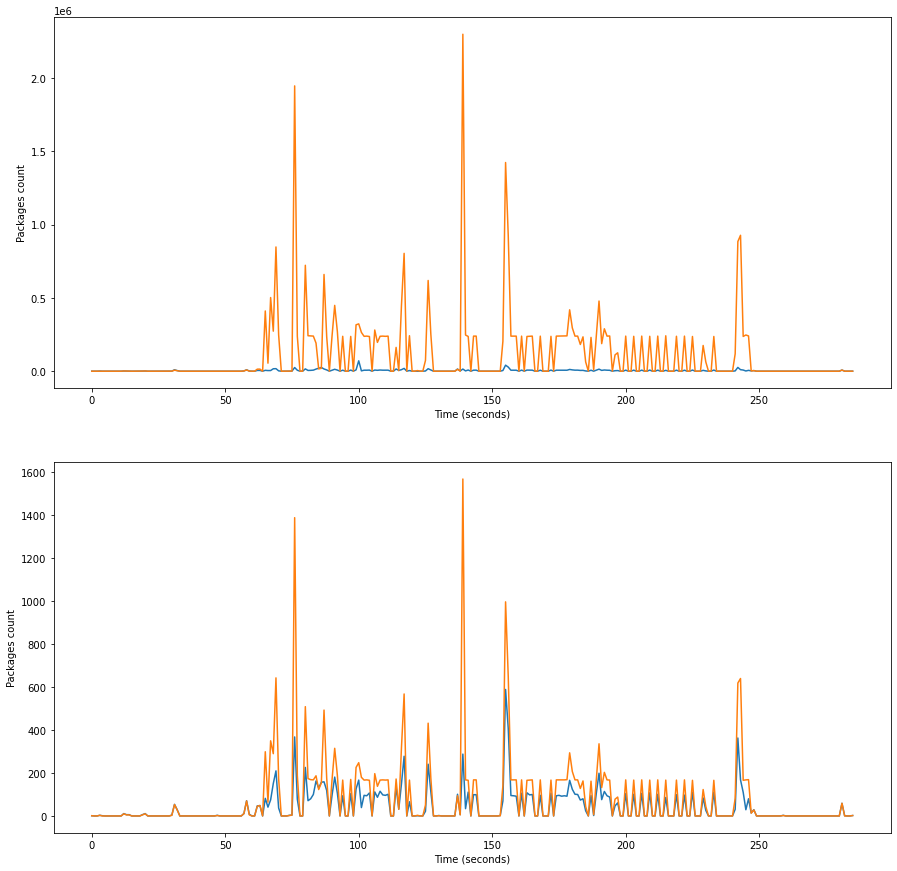

Traffic from test in normal.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in normal.txt mode Precision: 1.0 Recall: 1.0 F1-Score: 1.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in brute_isolated.txt mode


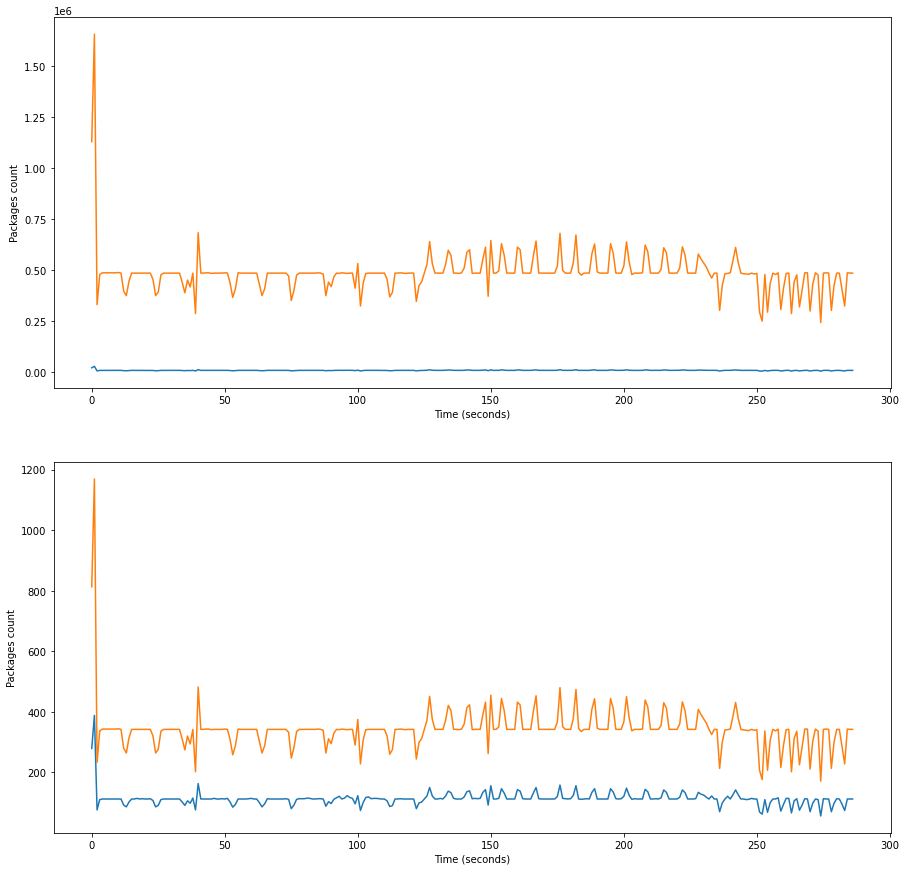

Traffic from test in brute_isolated.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in brute_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in brute_mixed.txt mode


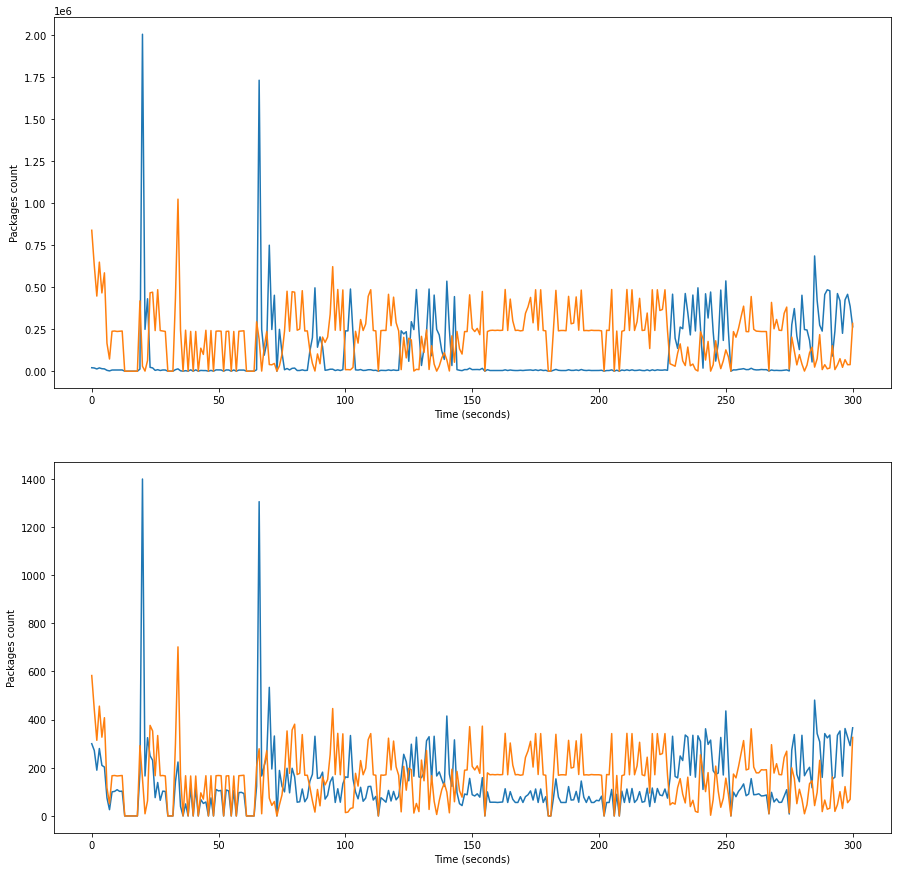

Traffic from test in brute_mixed.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in brute_mixed.txt mode Precision: 1.0 Recall: 0.2 F1-Score: 0.33 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in smooth_isolated.txt mode


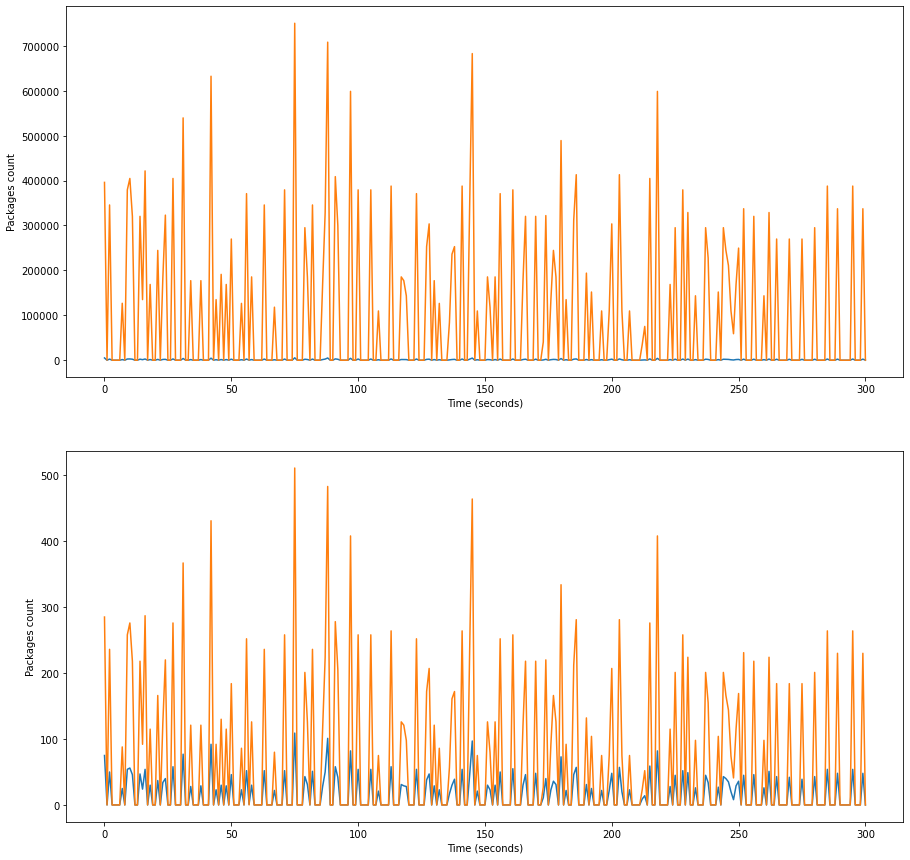

Traffic from test in smooth_isolated.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in smooth_isolated.txt mode Precision: 0.5 Recall: 0.0 F1-Score: 0.0 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in smooth_mixed.txt mode


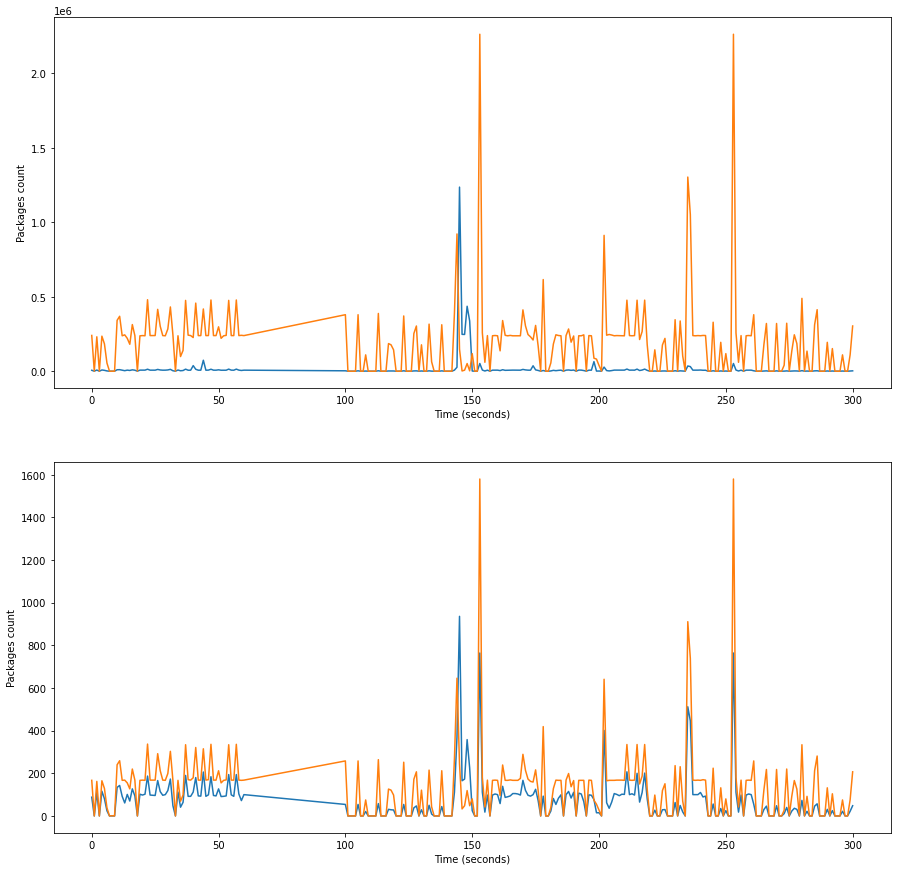

Traffic from test in smooth_mixed.txt mode
[1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores:
test in smooth_mixed.txt mode Precision: 1.0 Recall: 0.23 F1-Score: 0.38 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0



Traffic from test in intelligent.txt mode


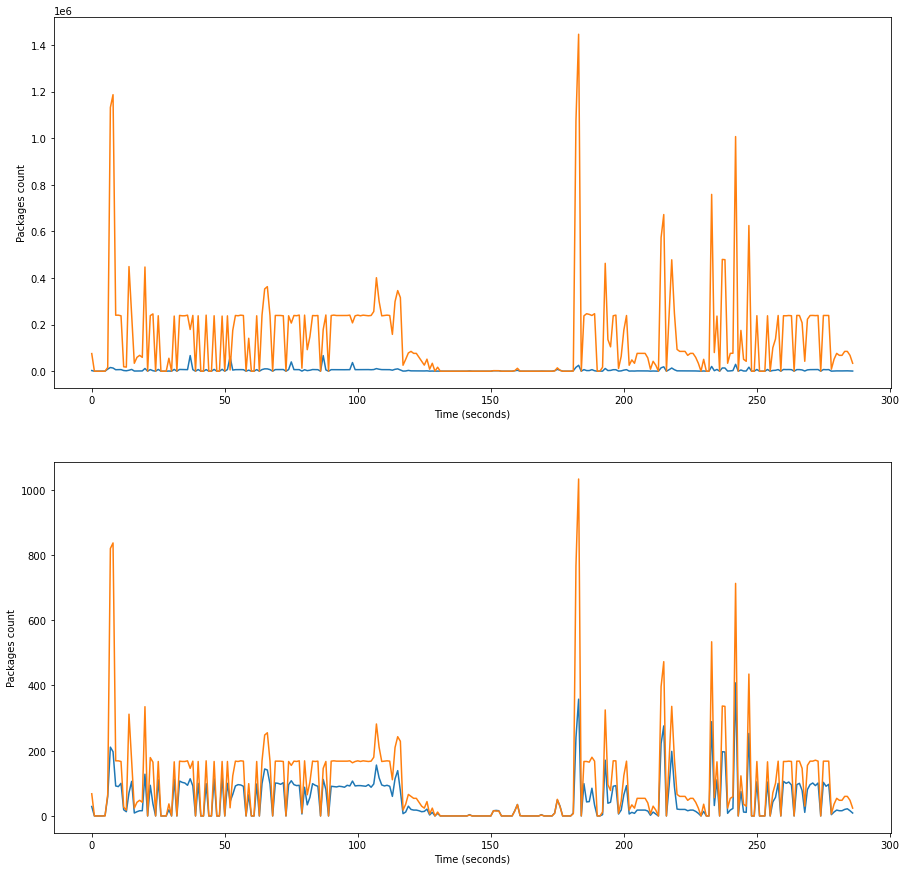

Traffic from test in intelligent.txt mode
[ 1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Scores:
test in intelligent.txt mode Precision: 1.0 Recall: 0.29 F1-Score: 0.44 Alert (%): 0.0
Num Alerts: 0
Alert (%): 0.0





In [22]:
testFiles=[(datasets["test"]["normal"], [-1]), 
            (datasets["test"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in testFiles:
    process(dataInput, botWin, "pca_svm")